## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas and adapted and used by: Alexander Golab, Karim Said and Guilherme Costa Ferreira for the project

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
# Pip install if needed
!{sys.executable} -m pip install gdown h5py

# Main imports for week 6
import sys
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import pickle
import os
import os
import json
import joblib
import numpy as np
import scipy.stats as stats

# Main function imports
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler

# Dataset download if needed
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

/bin/bash: line 1: {sys.executable}: command not found


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=c728aa52-4cb0-481f-8530-4686d61c9582
To: /home/ghenriqu/IT_data.h5
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384M/384M [00:03<00:00, 123MB/s]


'IT_data.h5'

## Load the data
Fetch the dataset after downloading it and a quick inspection

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [3]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

print(stimulus_train.shape)
print(spikes_train.shape)

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224
(2592, 3, 224, 224)
(2592, 168)


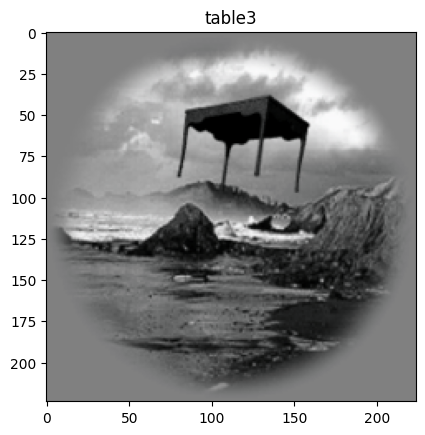

In [4]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

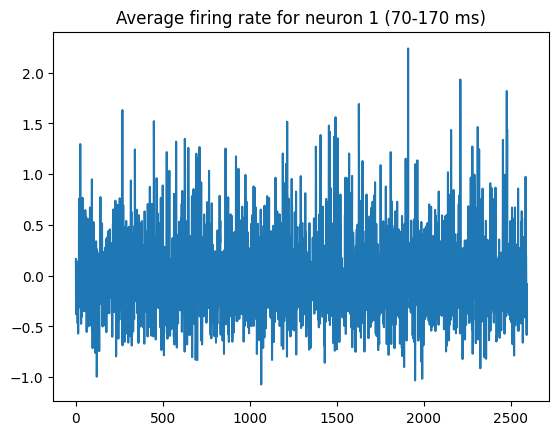

In [5]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels
Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [6]:
#### Reshape the input
stimulus_train_reshape = stimulus_train.reshape(n_stimulus, n_channels * img_size * img_size)
stimulus_val_reshape = stimulus_val.reshape(stimulus_val.shape[0], n_channels * img_size * img_size)
stimulus_test_reshape = stimulus_test.reshape(stimulus_test.shape[0], n_channels * img_size * img_size)

### Standardizxe with standard scaler
scaler = StandardScaler()
scaler.fit(stimulus_train_reshape)
stimulus_train_reshape = scaler.transform(stimulus_train_reshape)
stimulus_val_reshape = scaler.transform(stimulus_val_reshape)
stimulus_test_reshape = scaler.transform(stimulus_test_reshape)

In [7]:
# Linear regression on train
linear_regression = LinearRegression()

# Run if you want to train the model
#linear_regression.fit(stimulus_train_reshape, spikes_train)
#os.system('afplay /System/Library/Sounds/Ping.aiff') # Notifies when the code is done

# Run if you dont want to train the model
filename = 'NORMALIZED_simple_linear_non_reg.sav'
loaded_model = pickle.load(open(filename, 'rb'))
linear_regression = loaded_model

predictions_train = linear_regression.predict(stimulus_train_reshape)
predictions_val = linear_regression.predict(stimulus_val_reshape)

/home/ghenriqu/miniconda3/envs/nx414/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Linear regression on train
Train explained variance score: 1.0
Train r2 score: 1.0
Validation explained variance score: -0.9233438372612
Validation r2 score: -0.9318324327468872


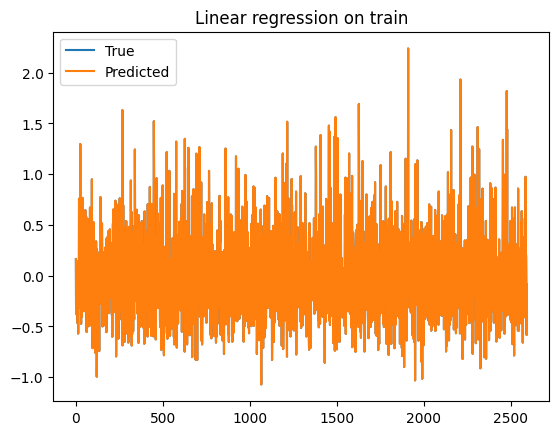

In [8]:
# Inspect
print('Linear regression on train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

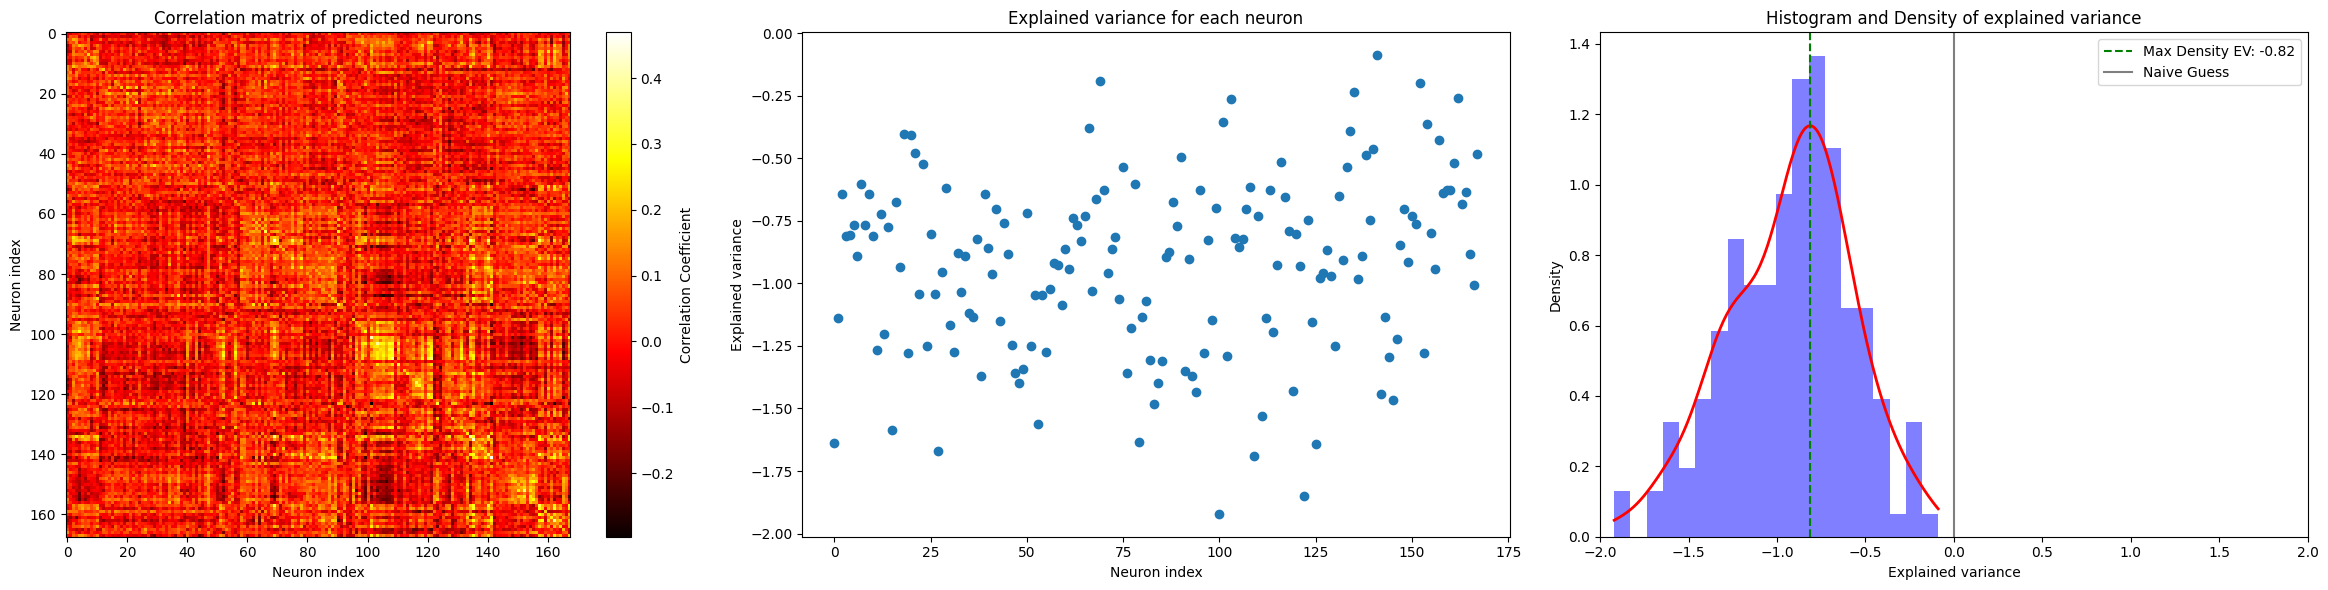

In [9]:
# Correlate the neurons of the model with each other and plot the correlation matrix
correlation_matrix = np.corrcoef(predictions_val.T, spikes_val.T)[:n_neurons, n_neurons:]

# Create the 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Correlation matrix ---
im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient')
axes[0].set_title('Correlation matrix of predicted neurons')
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Neuron index')

# --- Subplot 2: Explained variance scatter ---
ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val[:, i]) for i in range(n_neurons)]
axes[1].scatter(range(n_neurons), ev_scores)
axes[1].set_xlabel('Neuron index')
axes[1].set_ylabel('Explained variance')
axes[1].set_title('Explained variance for each neuron')

# --- Subplot 3: Histogram + density of explained variance ---
axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
density = stats.gaussian_kde(ev_scores)
x = np.linspace(min(ev_scores), max(ev_scores), 200)
axes[2].plot(x, density(x), 'r', linewidth=2)
max_density_val = x[np.argmax(density(x))]
axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
axes[2].set_xlabel('Explained variance')
axes[2].set_ylabel('Density')
axes[2].set_title('Histogram and Density of explained variance')
axes[2].set_xlim(-2, 2)
axes[2].legend()

plt.tight_layout()
plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity.

In [ ]:
# Apply PCA to the training data to reduce dimensionality of every image down to 1000 components
pca = PCA(n_components=1000)
pca.fit(stimulus_train_reshape)

# Transform the training, validation and test data
stimulus_train_pca = pca.transform(stimulus_train_reshape)
stimulus_val_pca = pca.transform(stimulus_val_reshape)
stimulus_test_pca = pca.transform(stimulus_test_reshape)

# Check the shape of the PCA transformed data
print(stimulus_train_pca.shape)
print(stimulus_val_pca.shape)

#os.system('afplay /System/Library/Sounds/Ping.aiff') # Notifies when the code is done

(2592, 1000)
(288, 1000)


In [ ]:
# Delete pre PCA data (only needed if ram is an issue)
'''
del stimulus_train_reshape
del stimulus_val_reshape
del stimulus_test_reshape
'''

'\ndel stimulus_train_reshape\ndel stimulus_val_reshape\ndel stimulus_test_reshape\n'

In [ ]:
# Apply normal linear regression to the PCA transformed data
linear_regression_pca = LinearRegression()
linear_regression_pca.fit(stimulus_train_pca, spikes_train)
predictions_train_pca = linear_regression_pca.predict(stimulus_train_pca)
predictions_val_pca = linear_regression_pca.predict(stimulus_val_pca)

Linear regression on PCA train
Train explained variance score: 0.46765875816345215
Train r2 score: 0.46765872836112976
Validation explained variance score: -0.07427563518285751
Validation r2 score: -0.07855673134326935


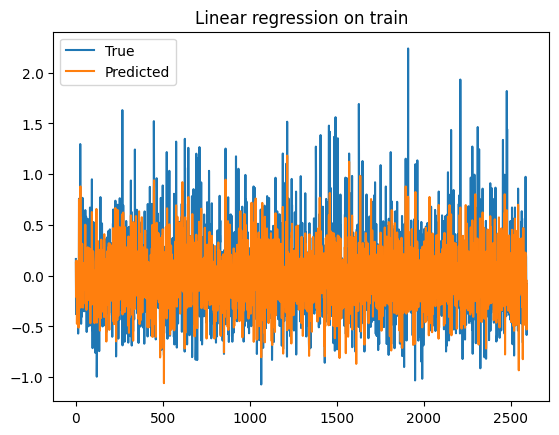

In [ ]:
# Inspect
print('Linear regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_pca)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_pca)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_pca)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_pca)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train_pca[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

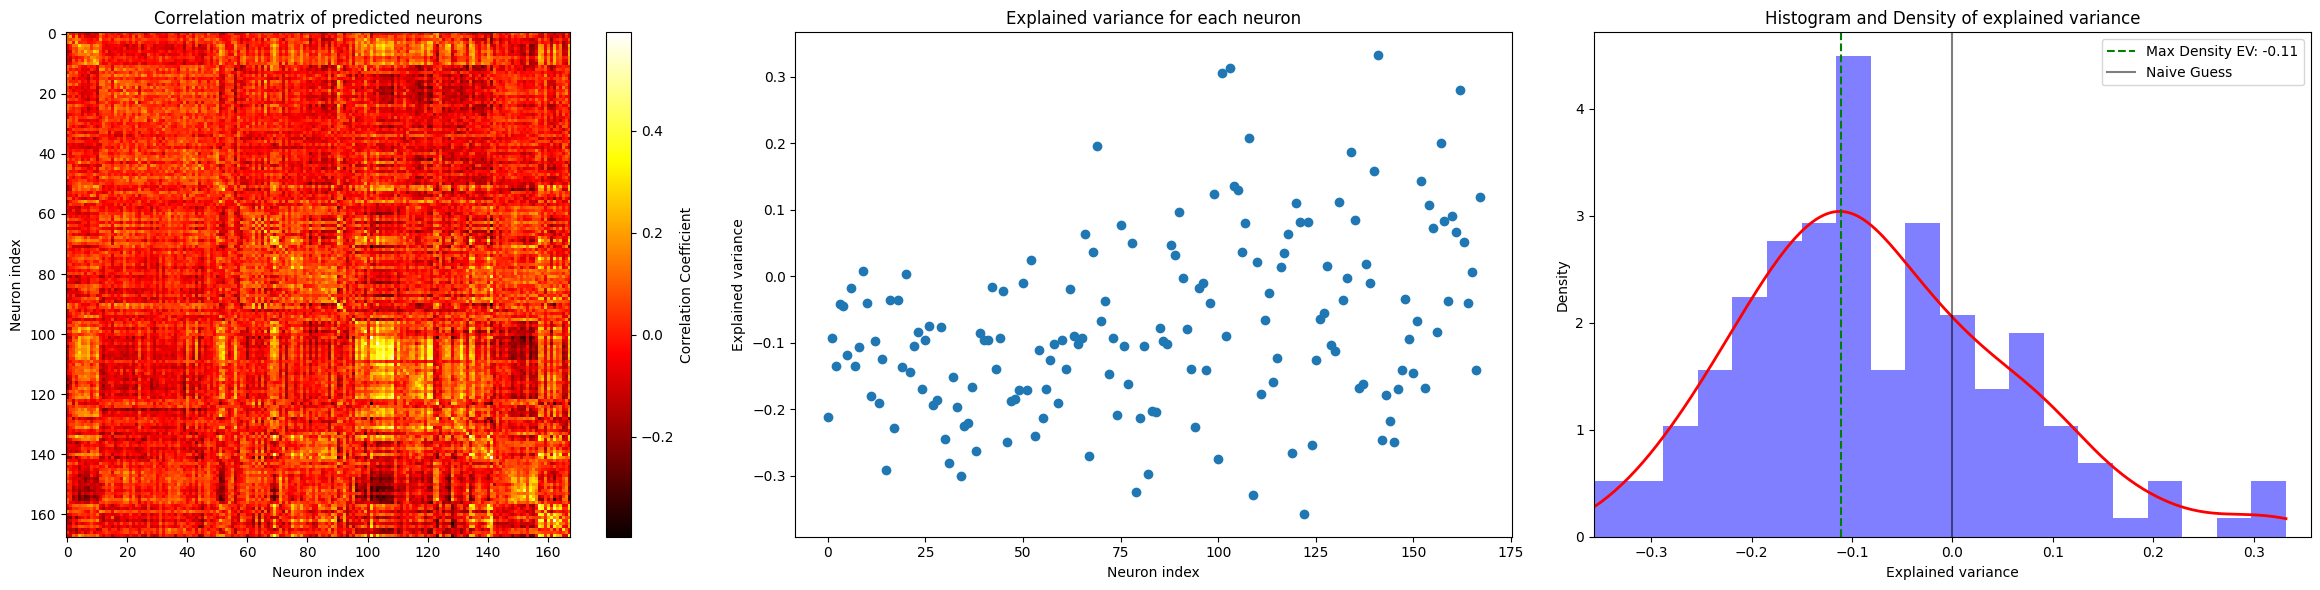

In [ ]:
# Correlate the neurons of the model with the actual predictions and plot the correlation matrix
correlation_matrix = np.corrcoef(predictions_val_pca.T, spikes_val.T)[:n_neurons, n_neurons:]

# Create the 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Correlation matrix ---
im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient')
axes[0].set_title('Correlation matrix of predicted neurons')
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Neuron index')

# --- Subplot 2: Explained variance scatter ---
ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_pca[:, i]) for i in range(n_neurons)]
axes[1].scatter(range(n_neurons), ev_scores)
axes[1].set_xlabel('Neuron index')
axes[1].set_ylabel('Explained variance')
axes[1].set_title('Explained variance for each neuron')

# --- Subplot 3: Histogram + density of explained variance ---
axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
density = stats.gaussian_kde(ev_scores)
x = np.linspace(min(ev_scores), max(ev_scores), 200)
most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
axes[2].plot(x, density(x), 'r', linewidth=2)
max_density_val = x[np.argmax(density(x))]
axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
axes[2].set_xlabel('Explained variance')
axes[2].set_ylabel('Density')
axes[2].set_title('Histogram and Density of explained variance')
axes[2].set_xlim(-most_extreme, most_extreme)
axes[2].legend()

plt.tight_layout()
plt.show()

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
# Perform ridge regression on the PCA transformed training data using cross-validation to find the best alpha value
ridge = Ridge()
alphas = np.linspace(0, 1e7, 200)
param_grid = {'alpha': alphas}

# Use explained variance as the scoring metric
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(stimulus_train_pca, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print('Best alpha value: {}'.format(best_alpha))

# Apply ridge regression with the best alpha value
ridge = Ridge(alpha=best_alpha)
ridge.fit(stimulus_train_pca, spikes_train)
predictions_train_ridge = ridge.predict(stimulus_train_pca)
predictions_val_ridge = ridge.predict(stimulus_val_pca)

os.system('afplay /System/Library/Sounds/Ping.aiff') # Notifies when the code is done

Best alpha value: 452261.3065326633


Ridge regression on PCA train
Train explained variance score: 0.17685307562351227
Train r2 score: 0.17685307562351227
Validation explained variance score: 0.09162304550409317
Validation r2 score: 0.08751915395259857


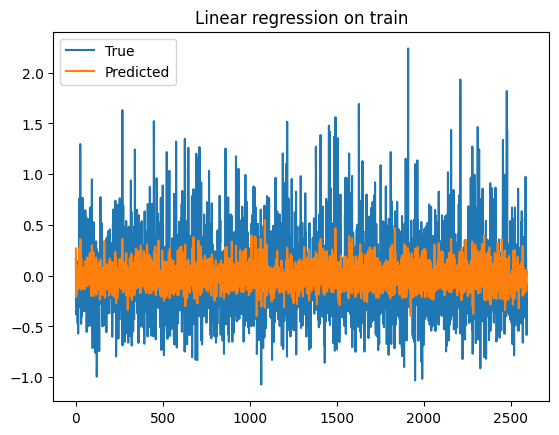

In [ ]:
# Inspect
print('Ridge regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_ridge)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_ridge)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_ridge)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_ridge)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train_ridge[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

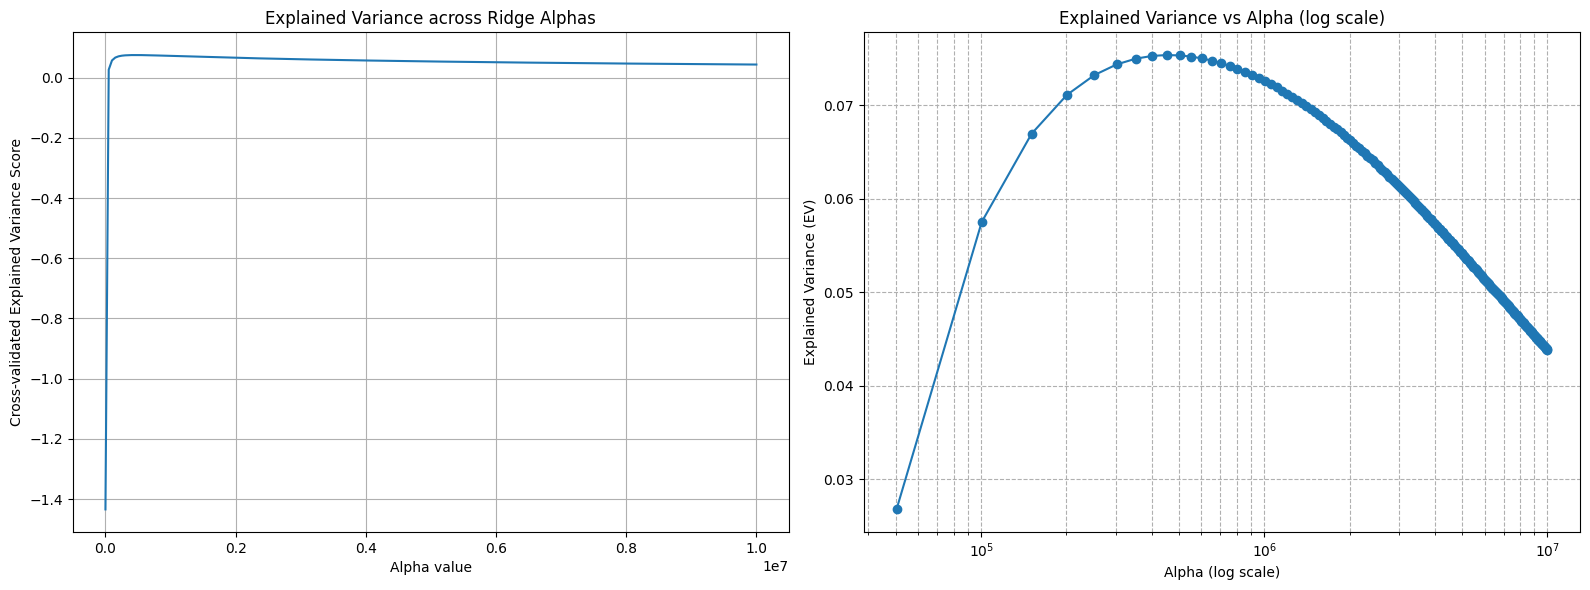

In [ ]:
# plot the explained variance for each alpha value
mean_scores = grid_search.cv_results_['mean_test_score']

# Avoid log(0) by replacing alpha=0 with a very small number for plotting
alphas_for_plot = np.copy(alphas)
alphas_for_plot[alphas_for_plot == 0] = 1e-8  # tiny value instead of 0

# Plot both versions as subplots in a single figure
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: standard plot
ax[0].plot(alphas, mean_scores)
ax[0].set_xlabel('Alpha value')
ax[0].set_ylabel('Cross-validated Explained Variance Score')
ax[0].set_title('Explained Variance across Ridge Alphas')
ax[0].grid(True)

# Right subplot: semilogx plot
ax[1].semilogx(alphas_for_plot[1:], mean_scores[1:], marker='o')
ax[1].set_xlabel('Alpha (log scale)')
ax[1].set_ylabel('Explained Variance (EV)')
ax[1].set_title('Explained Variance vs Alpha (log scale)')
ax[1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

# The EV improves until around 0 for higher alphas, but we lose significant performance on the training set wich proves that ridge won't help us to generalize better

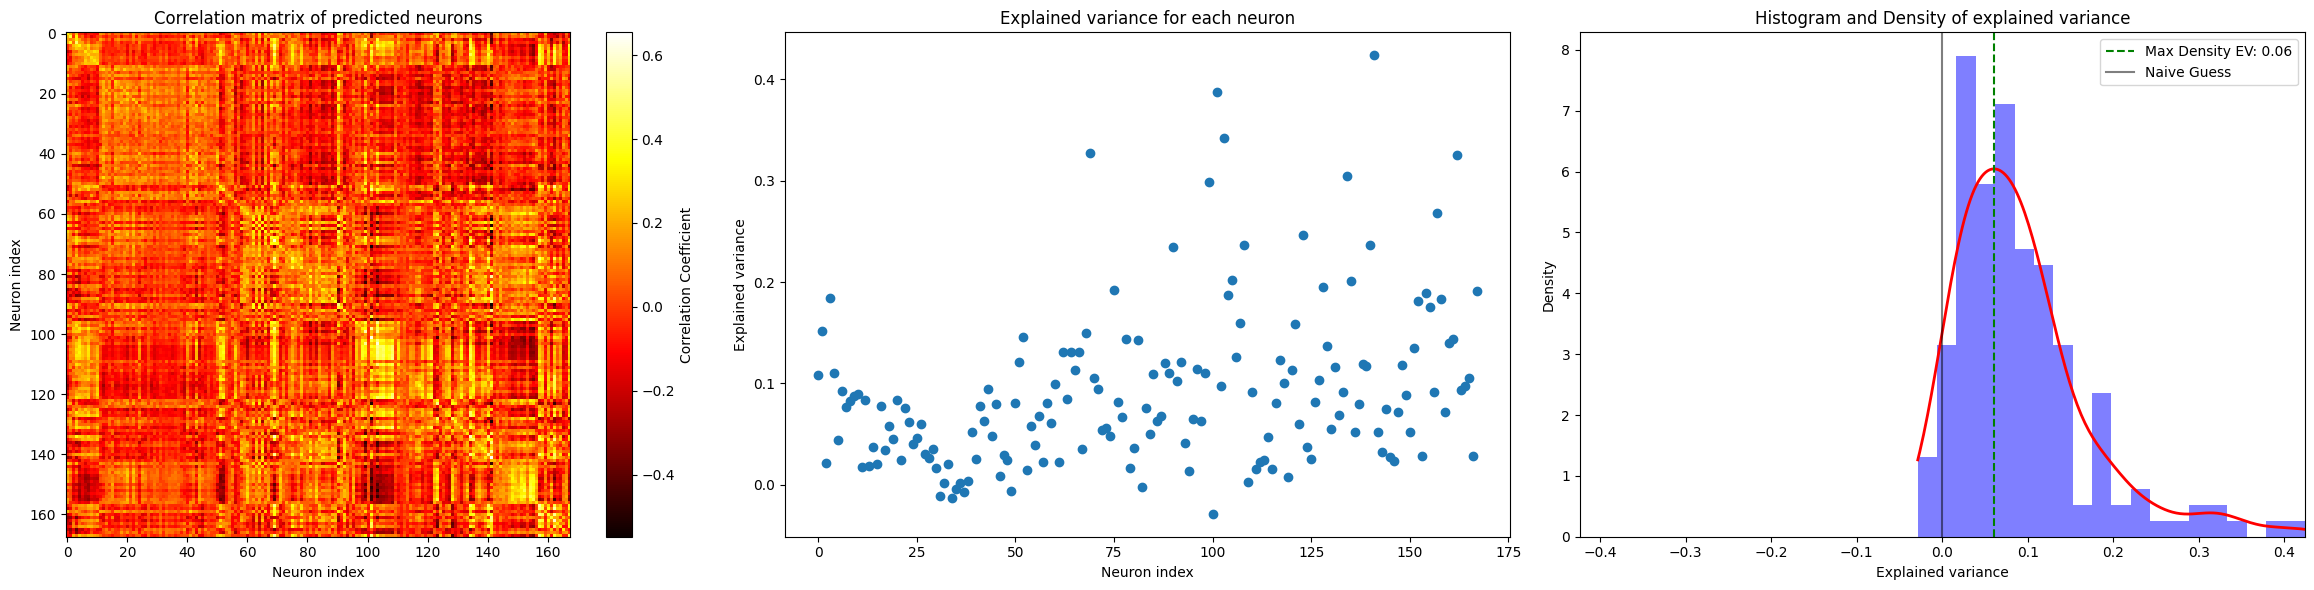

In [ ]:
# Correlate the neurons of the model with each other and plot the correlation matrix
correlation_matrix = np.corrcoef(predictions_val_ridge.T, spikes_val.T)[:n_neurons, n_neurons:]

# Create the 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Correlation matrix ---
im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient')
axes[0].set_title('Correlation matrix of predicted neurons')
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Neuron index')

# --- Subplot 2: Explained variance scatter ---
ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_ridge[:, i]) for i in range(n_neurons)]
axes[1].scatter(range(n_neurons), ev_scores)
axes[1].set_xlabel('Neuron index')
axes[1].set_ylabel('Explained variance')
axes[1].set_title('Explained variance for each neuron')

# --- Subplot 3: Histogram + density of explained variance ---
axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
density = stats.gaussian_kde(ev_scores)
x = np.linspace(min(ev_scores), max(ev_scores), 200)
most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
axes[2].plot(x, density(x), 'r', linewidth=2)
max_density_val = x[np.argmax(density(x))]
axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
axes[2].set_xlabel('Explained variance')
axes[2].set_ylabel('Density')
axes[2].set_title('Histogram and Density of explained variance')
axes[2].set_xlim(-most_extreme, most_extreme)
axes[2].legend()

plt.tight_layout()
plt.show()

We can see that the explained variance improves as the alpha increases until alpha reaches 32.000. After that the perfomance starts to reduce as the model underfits. The best Ridge model achieves positive EV for almost every neuron, even though it does not get very high values.  This is actually expected, since individual pixels in an image do not necessitate being able to understand the entire image. Especially in IT neurons, which fire based on the actual image and require a holistic understanding of the image and context. Even when applying PCA, we are still effectively getting pieces of the image that represent the largest variance, rather than the object itself.

What might solve this is a task driven modeling approach, where we could model our network as the brain does at the level of the IT, rather than at a retinal level as is done above, with individual pixels being used for classification.

## Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

### Function Imports

In [10]:
# Check if using gpus
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # remove gpus as tensorflow had some issues with the GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("\nNum GPUs Available: ", len(gpus), "\n")

import keras
from keras.applications import ResNet50
from keras.models import Model

from keras import backend as K

from keras.applications.resnet50 import preprocess_input

from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score
import joblib
from scipy.stats import gaussian_kde

2025-05-07 12:56:15.863588: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 12:56:19.278915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746615380.120423 1591631 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746615380.300681 1591631 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746615381.998559 1591631 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


Num GPUs Available:  0 



2025-05-07 12:57:00.113667: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-07 12:57:00.114434: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-05-07 12:57:00.114814: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-05-07 12:57:00.114821: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-07 12:57:00.114836: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: i17
2025-05-07 12:57:00.115181: I external/local_xla/xla/stream_executor/cuda/cuda_diag

In [11]:
#### Here your code
# Get a pretrained resnet50 model
K.clear_session()

# Load model
pre_trained_model = ResNet50(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))

# Map their conceptual layer names to Keras layer names
layer_map = {
    'conv1': 'conv1_conv',
    'layer1': 'conv2_block3_out',
    'layer2': 'conv3_block4_out',
    'layer3': 'conv4_block6_out',
    'layer4': 'conv5_block3_out',
    'avgpool': 'avg_pool'
}
activation_model = Model(inputs=pre_trained_model.input, 
                         outputs=[pre_trained_model.get_layer(name).output for name in layer_map.values()])

In [12]:
X_train_prep = preprocess_input(stimulus_train)
X_test_prep = preprocess_input(stimulus_val)

X_train_prep = np.reshape(X_train_prep, (X_train_prep.shape[0], img_size, img_size, n_channels))
X_test_prep = np.reshape(X_test_prep, (X_test_prep.shape[0], img_size, img_size, n_channels))

### Pre-Trained Task-Driven Model

#### PCA Iniciation
Loop over the layers, and store the pca models for a specific layer inside a dictionary, only run this since it takes a lot of time to get the PCA layers.

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

layer_pca_models = {}
train_pca_activations = {}

n_components = 1000  # Number of PCA components
for i, (logical_name, keras_name) in enumerate(layer_map.items()):
    print(f"Processing layer: {logical_name}")
    
    # Extract activations
    layer_train_acts = activation_model.predict(X_train_prep)[i]
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)


    # Compute PCA
    print(f"    Computing PCA...")
    pca = PCA(n_components=n_components)
    train_pca = pca.fit_transform(flat_train)

    # Save PCA & scaler
    print(f"    Saving PCA model...")
    joblib.dump(pca, f'pca_{logical_name}.pkl')

    # Store projected features
    train_pca_activations[logical_name] = train_pca

Processing layer: conv1
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 255ms/step
    Computing PCA...
    Saving PCA model...
Processing layer: layer1
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step
    Computing PCA...
    Saving PCA model...
Processing layer: layer2
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 265ms/step
    Computing PCA...
    Saving PCA model...
Processing layer: layer3
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step
    Computing PCA...
    Saving PCA model...
Processing layer: layer4
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step
    Computing PCA...
    Saving PCA model...
Processing layer: avgpool
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step
    Computing PCA...
    Saving PCA model...


#### Inspection Functions
Functions to help inspect the data

In [13]:
def inspect_alphas(grid_search, alphas, name):
    # plot the explained variance for each alpha value
    mean_scores = grid_search.cv_results_['mean_test_score']

    # Avoid log(0) by replacing alpha=0 with a very small number for plotting
    alphas_for_plot = np.copy(alphas)
    alphas_for_plot[alphas_for_plot == 0] = 1e-8  # tiny value instead of 0

    # Plot both versions as subplots in a single figure
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Left subplot: standard plot
    ax[0].plot(alphas, mean_scores)
    ax[0].set_xlabel('Alpha value')
    ax[0].set_ylabel('Cross-validated Explained Variance Score')
    ax[0].set_title('Explained Variance across Ridge Alphas')
    ax[0].grid(True)

    # Right subplot: semilogx plot
    ax[1].semilogx(alphas_for_plot[1:], mean_scores[1:], marker='o')
    ax[1].set_xlabel('Alpha (log scale)')
    ax[1].set_ylabel('Explained Variance (EV)')
    ax[1].set_title('Explained Variance vs Alpha (log scale)')
    ax[1].grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.savefig(f'alphas_analysis_{name}.png')
    plt.show()

In [14]:
def inspect_ridge(predictions_train_ridge, predictions_val_ridge, spikes_val, name):
    # Correlate the neurons of the model with each other and plot the correlation matrix
    correlation_matrix = np.corrcoef(predictions_train_ridge.T)

    # Create the 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # --- Subplot 1: Correlation matrix ---
    im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Correlation Coefficient')
    axes[0].set_title('Correlation matrix of predicted neurons')
    axes[0].set_xlabel('Neuron index')
    axes[0].set_ylabel('Neuron index')

    # --- Subplot 2: Explained variance scatter ---
    ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_ridge[:, i]) for i in range(n_neurons)]
    axes[1].scatter(range(n_neurons), ev_scores)
    axes[1].set_xlabel('Neuron index')
    axes[1].set_ylabel('Explained variance')
    axes[1].set_title('Explained variance for each neuron')

    # --- Subplot 3: Histogram + density of explained variance ---
    axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
    density = gaussian_kde(ev_scores)
    x = np.linspace(min(ev_scores), max(ev_scores), 200)
    most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
    axes[2].plot(x, density(x), 'r', linewidth=2)
    max_density_val = x[np.argmax(density(x))]
    axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
    axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
    axes[2].set_xlabel('Explained variance')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Histogram and Density of explained variance')
    axes[2].set_xlim(-most_extreme, most_extreme)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(f'ridge_regression_analysis_{name}.png')
    plt.show()

#### Loop over layers
Loop over all the layers

Processing layer: conv1
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 8603464.416684508
    Predicting on test data...
conv1 → Mean Explained Variance: 0.0900
    Storing results...
    Inspecting results...


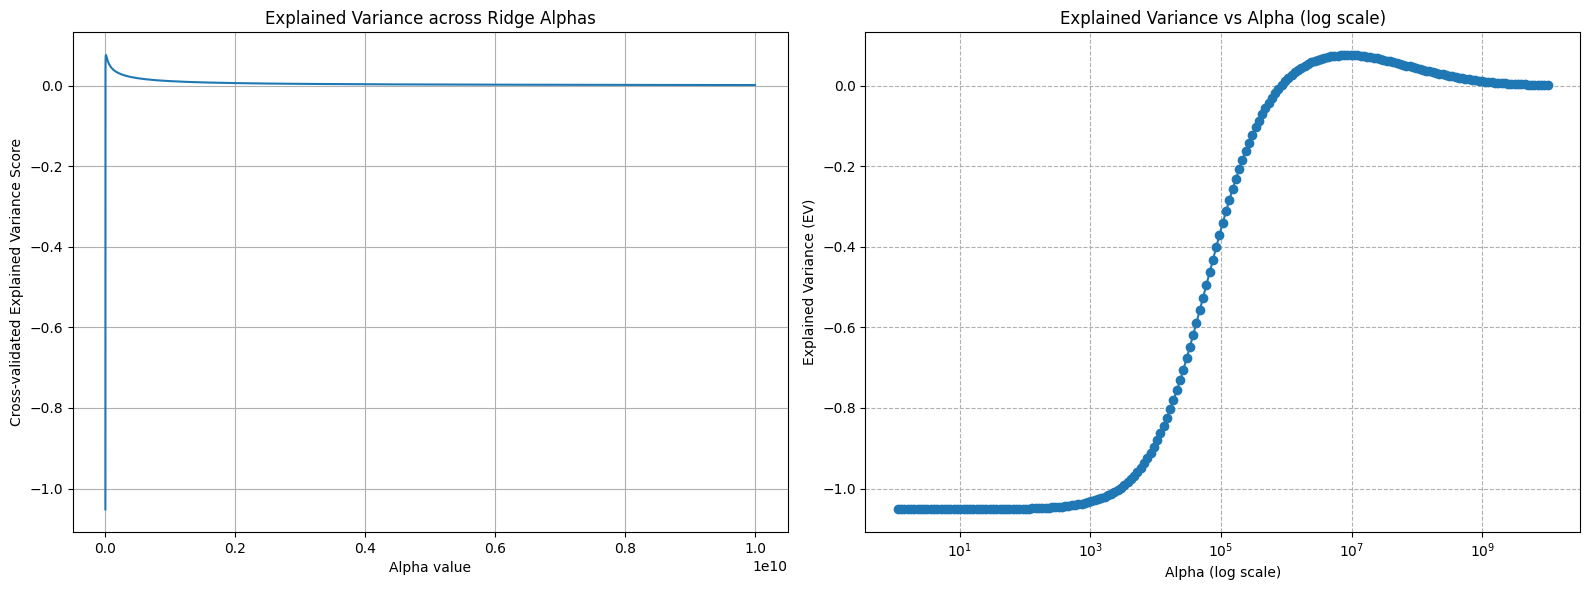

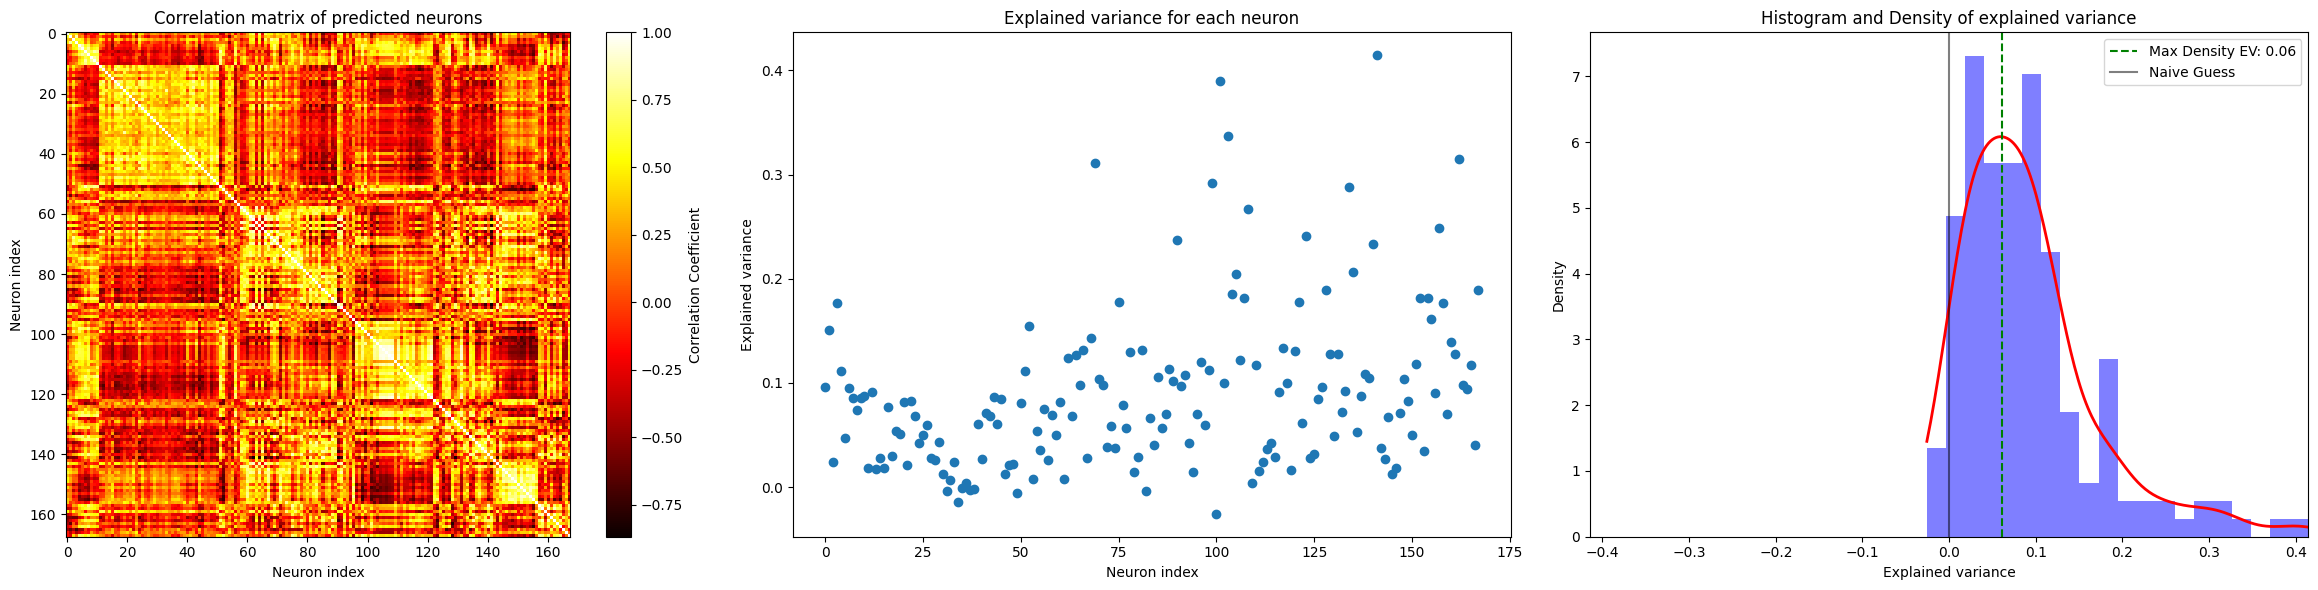


Processing layer: layer1
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 74881.03857590031
    Predicting on test data...
layer1 → Mean Explained Variance: 0.2540
    Storing results...
    Inspecting results...


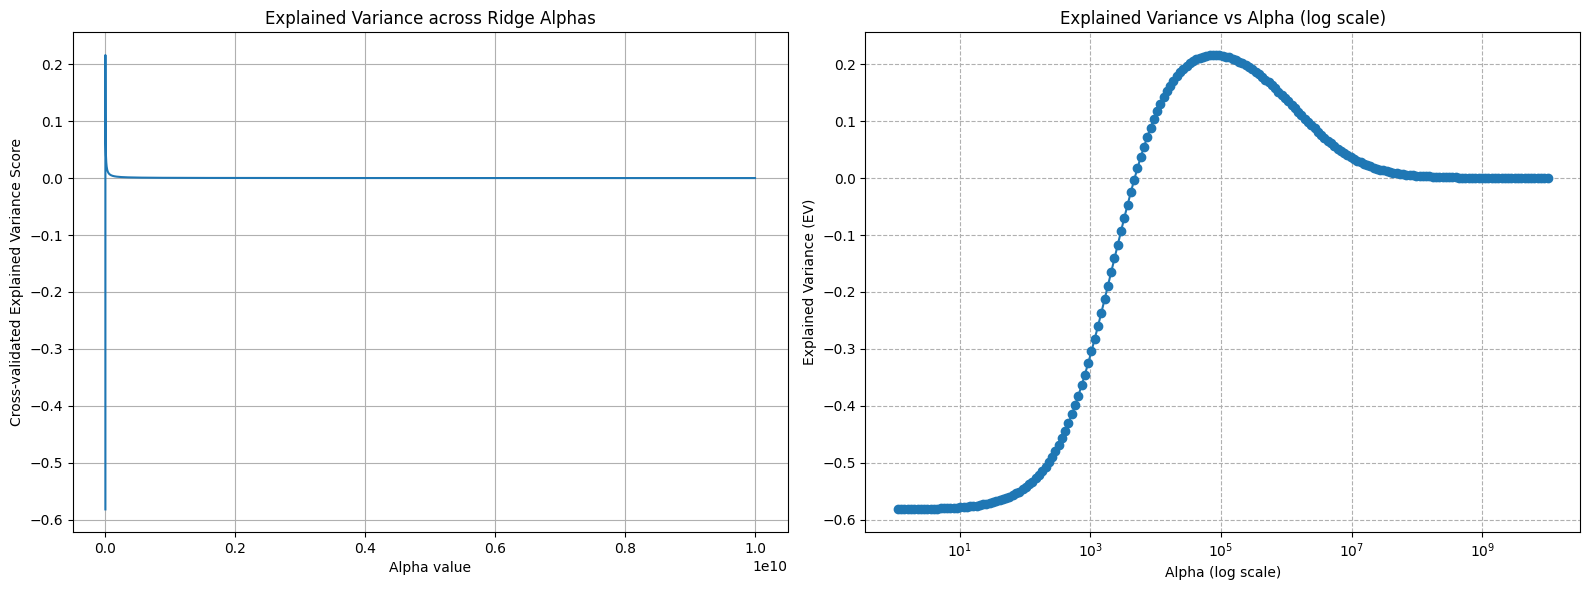

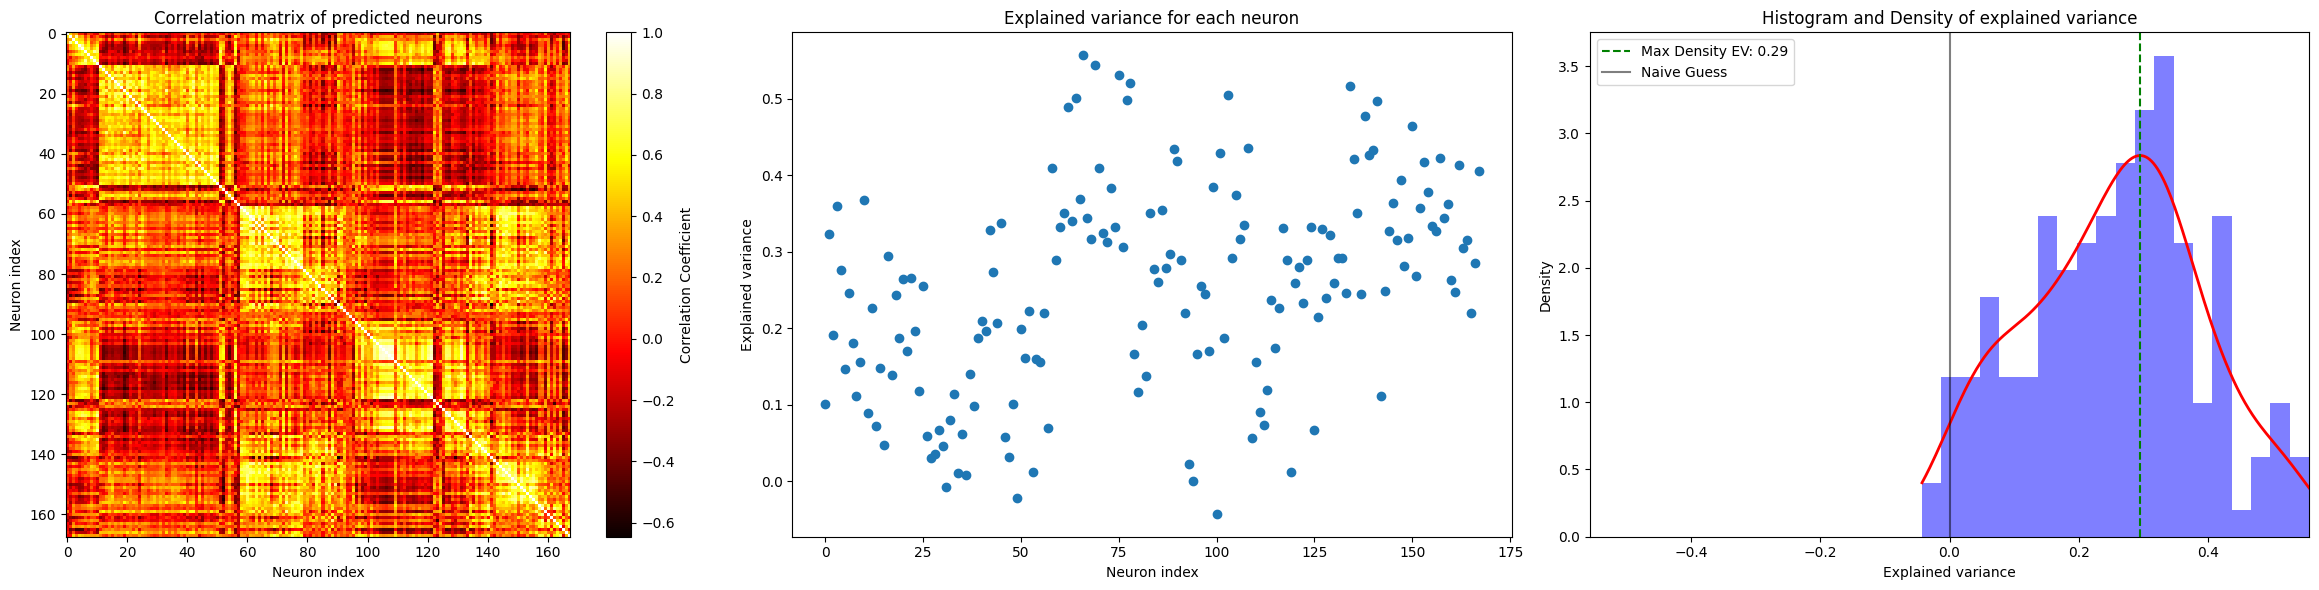


Processing layer: layer2
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 66699.19663030129
    Predicting on test data...
layer2 → Mean Explained Variance: 0.3079
    Storing results...
    Inspecting results...


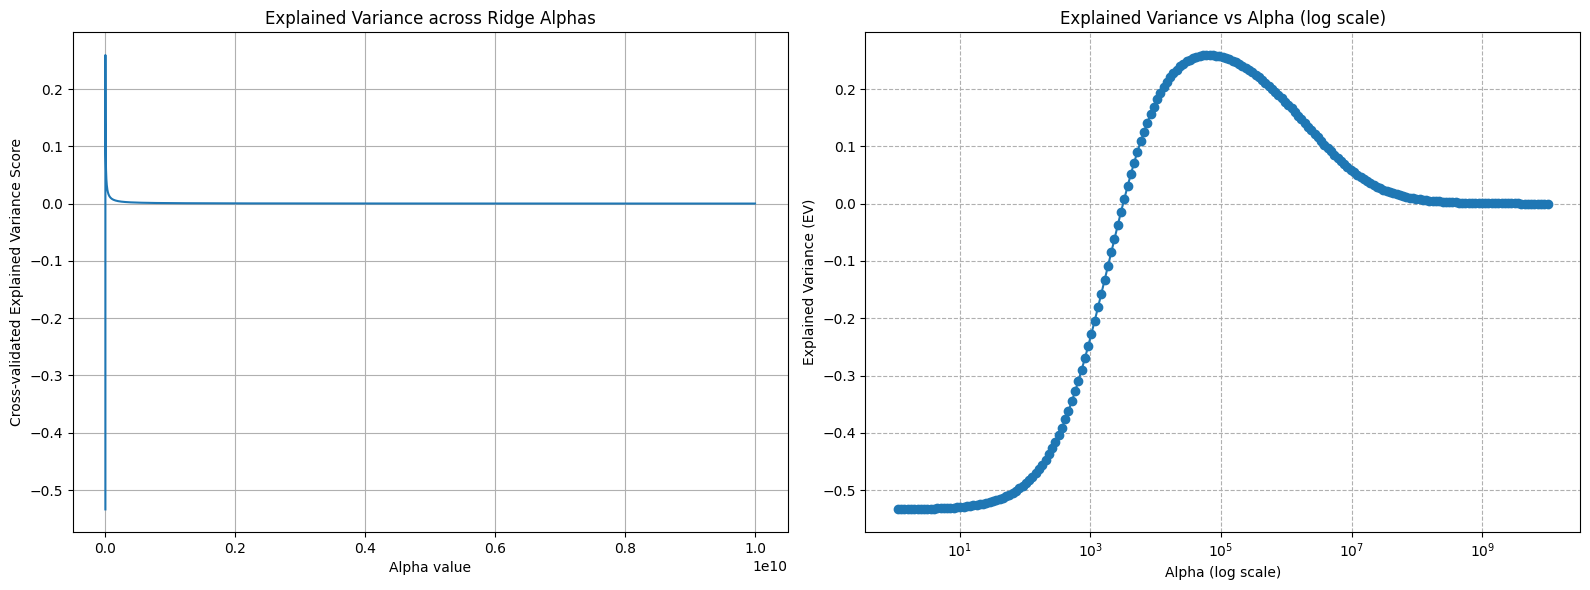

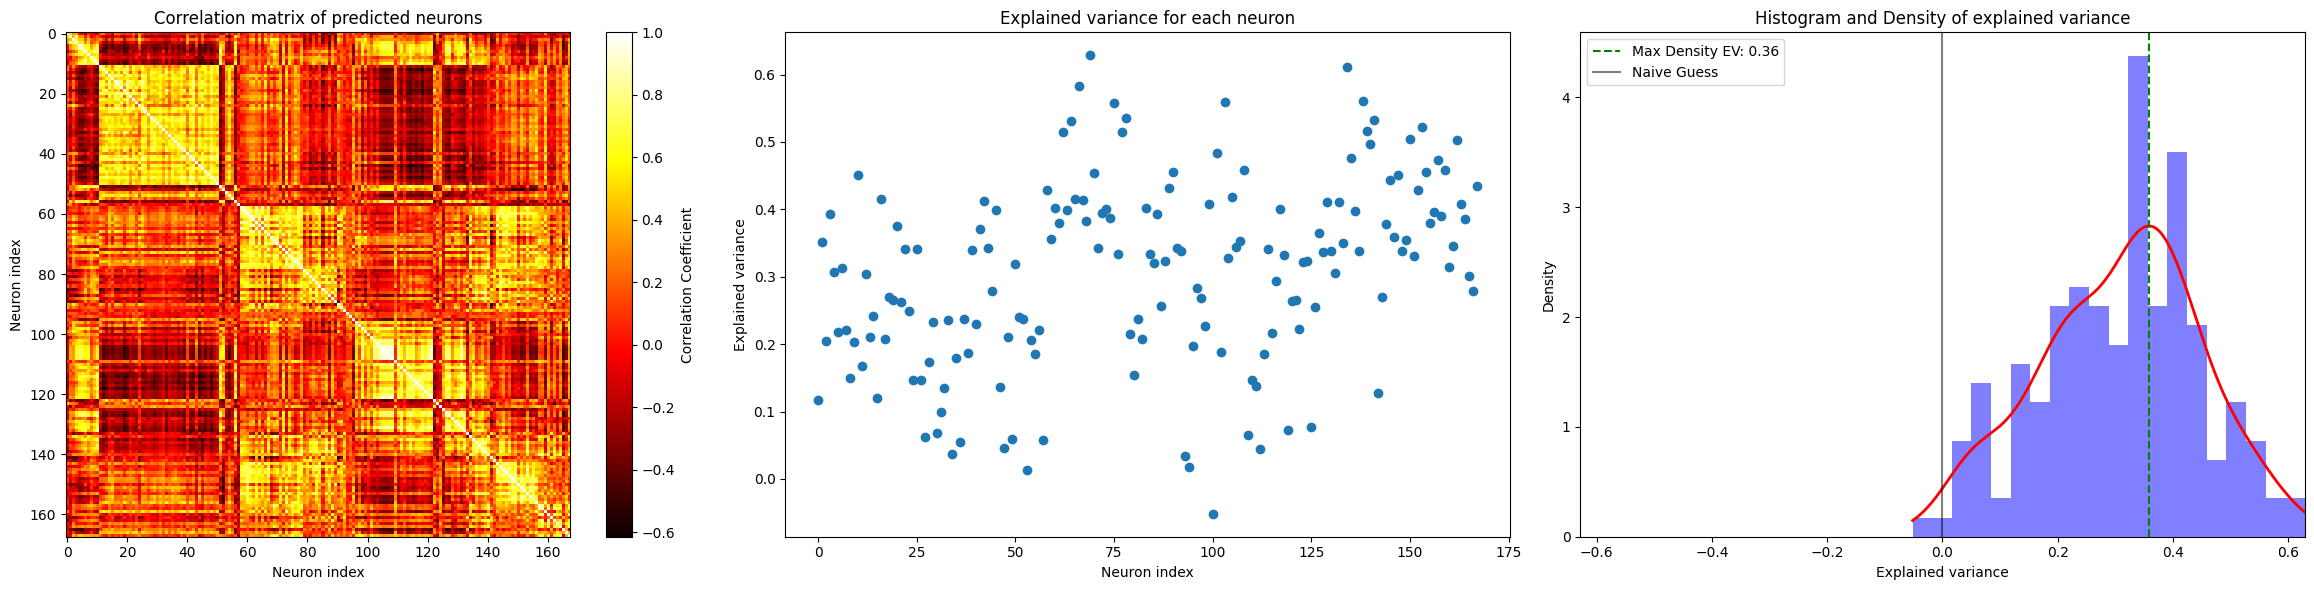


Processing layer: layer3
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 20970.46401323235
    Predicting on test data...
layer3 → Mean Explained Variance: 0.2832
    Storing results...
    Inspecting results...


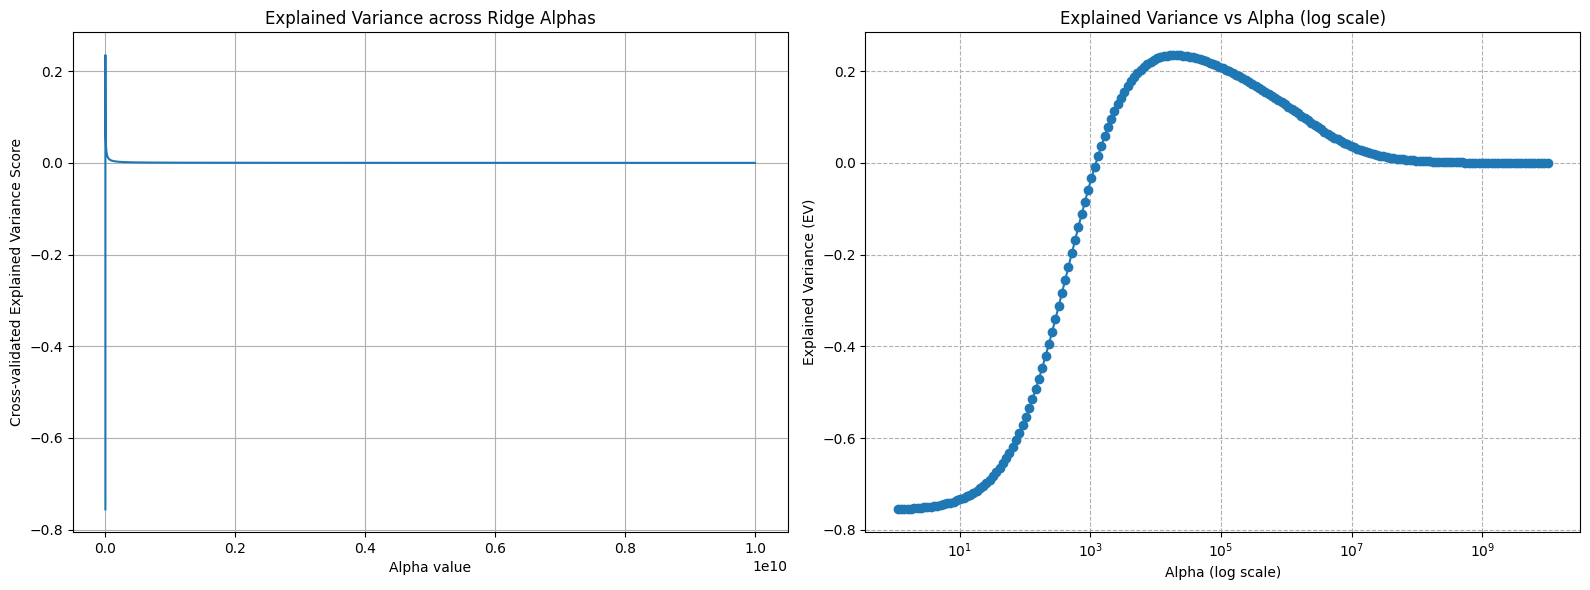

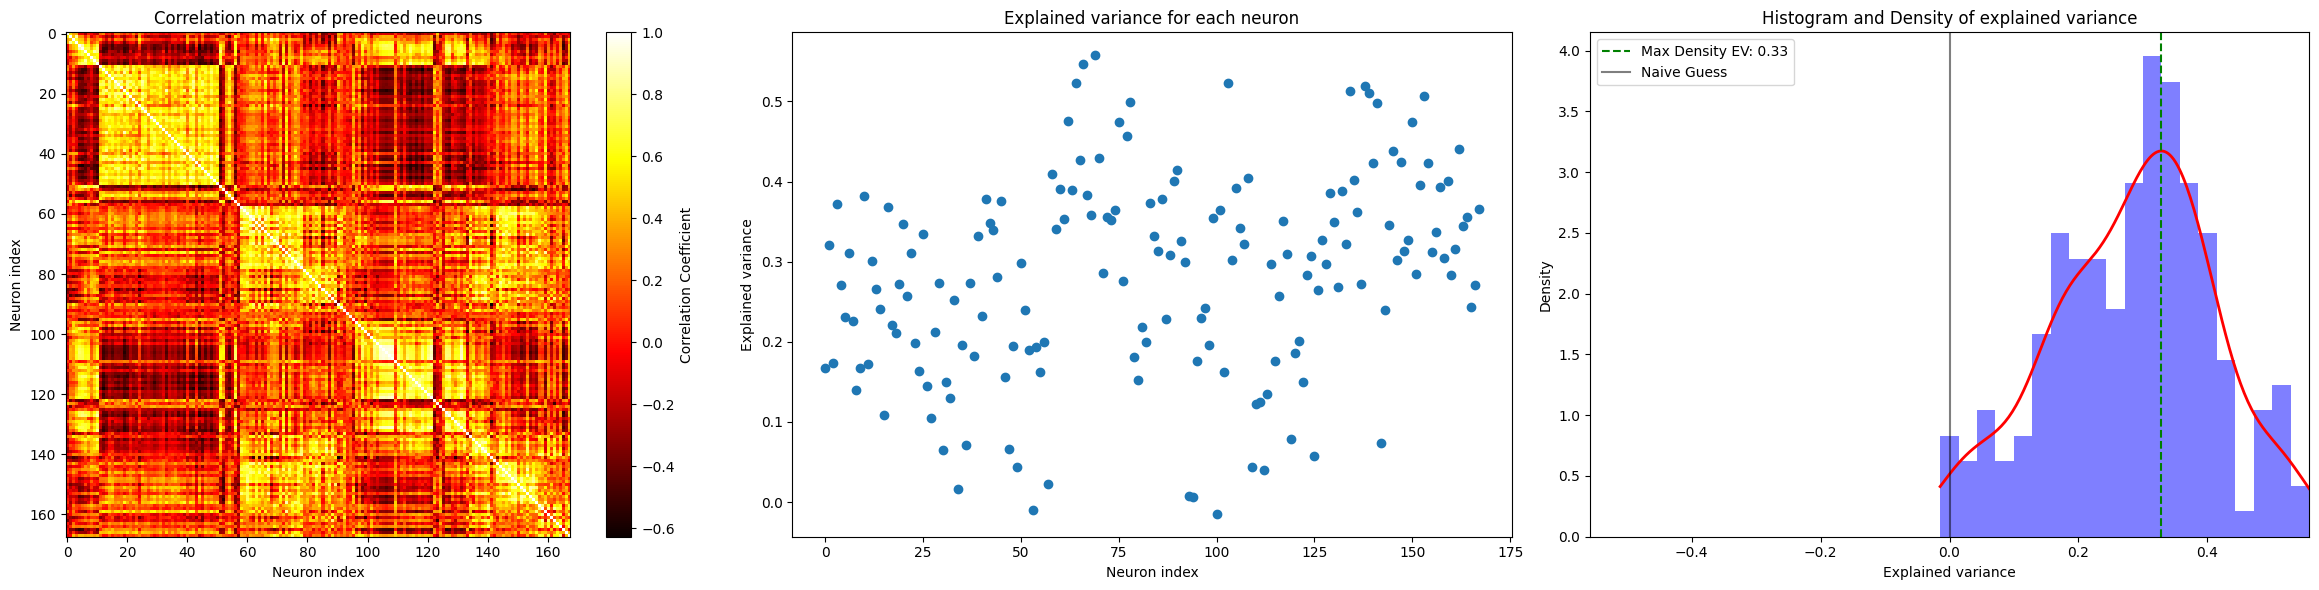


Processing layer: layer4
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 18679.135990207847
    Predicting on test data...
layer4 → Mean Explained Variance: 0.2419
    Storing results...
    Inspecting results...


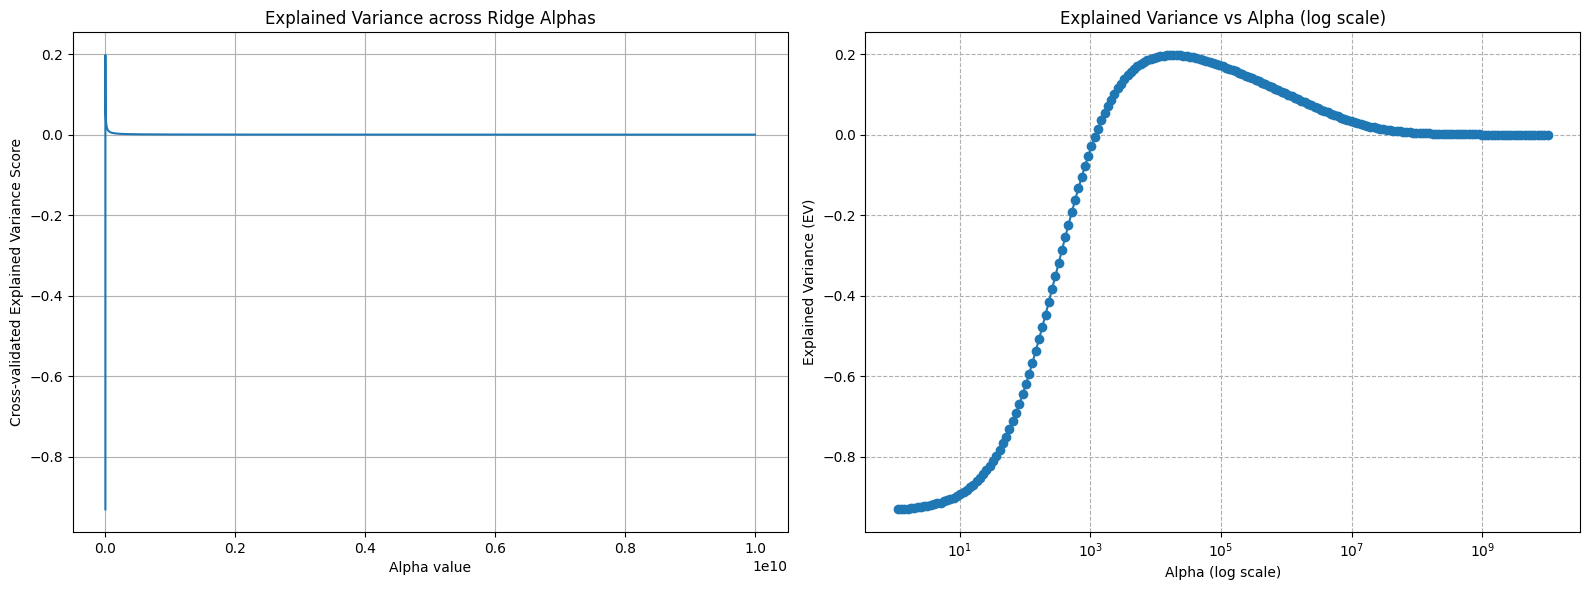

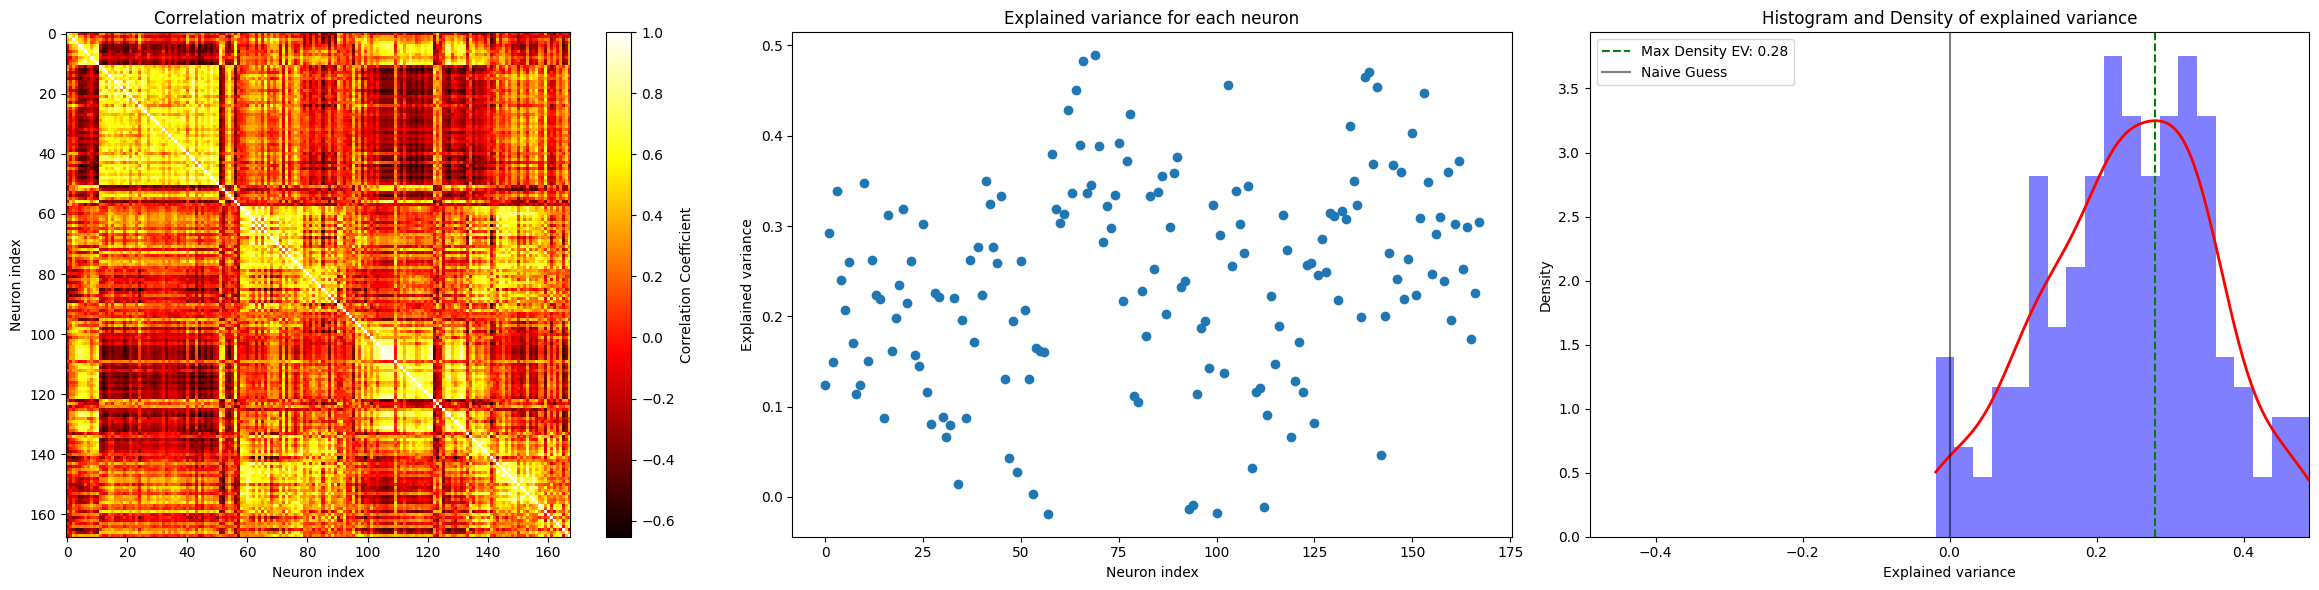


Processing layer: avgpool
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 64.42363508721374
    Predicting on test data...
avgpool → Mean Explained Variance: 0.1845
    Storing results...
    Inspecting results...


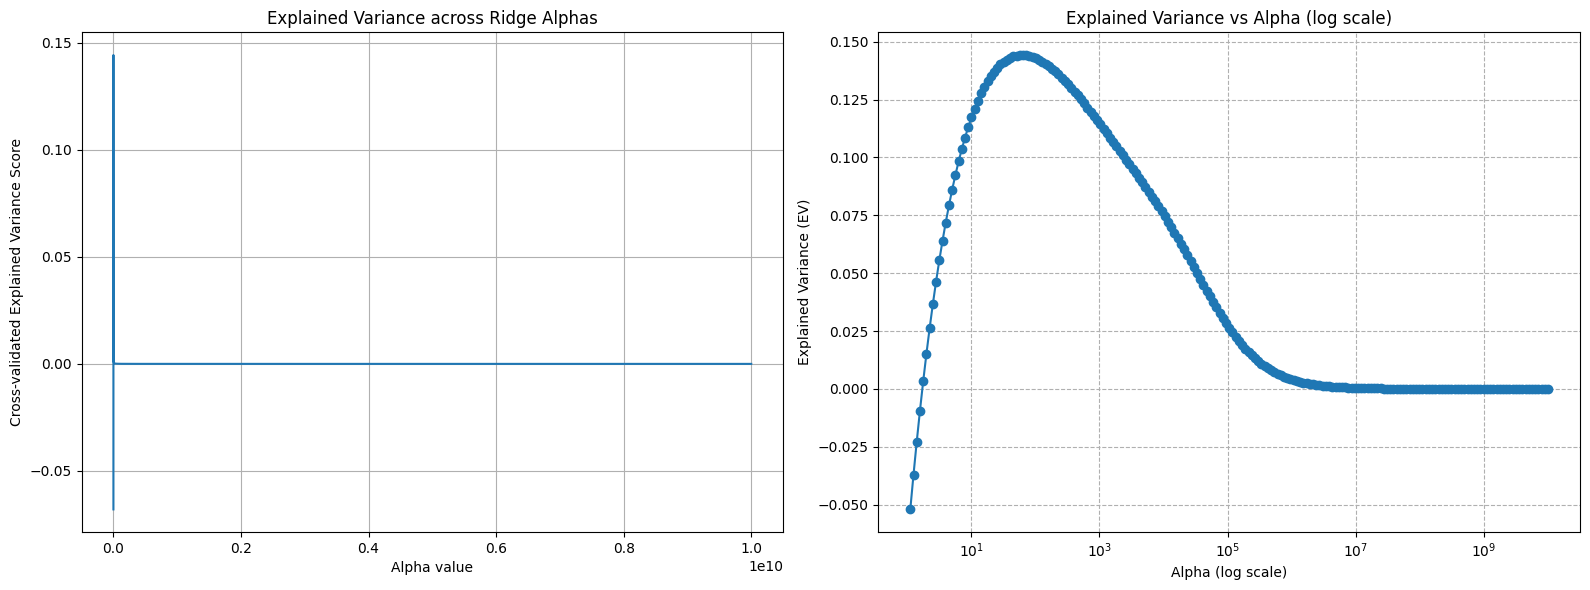

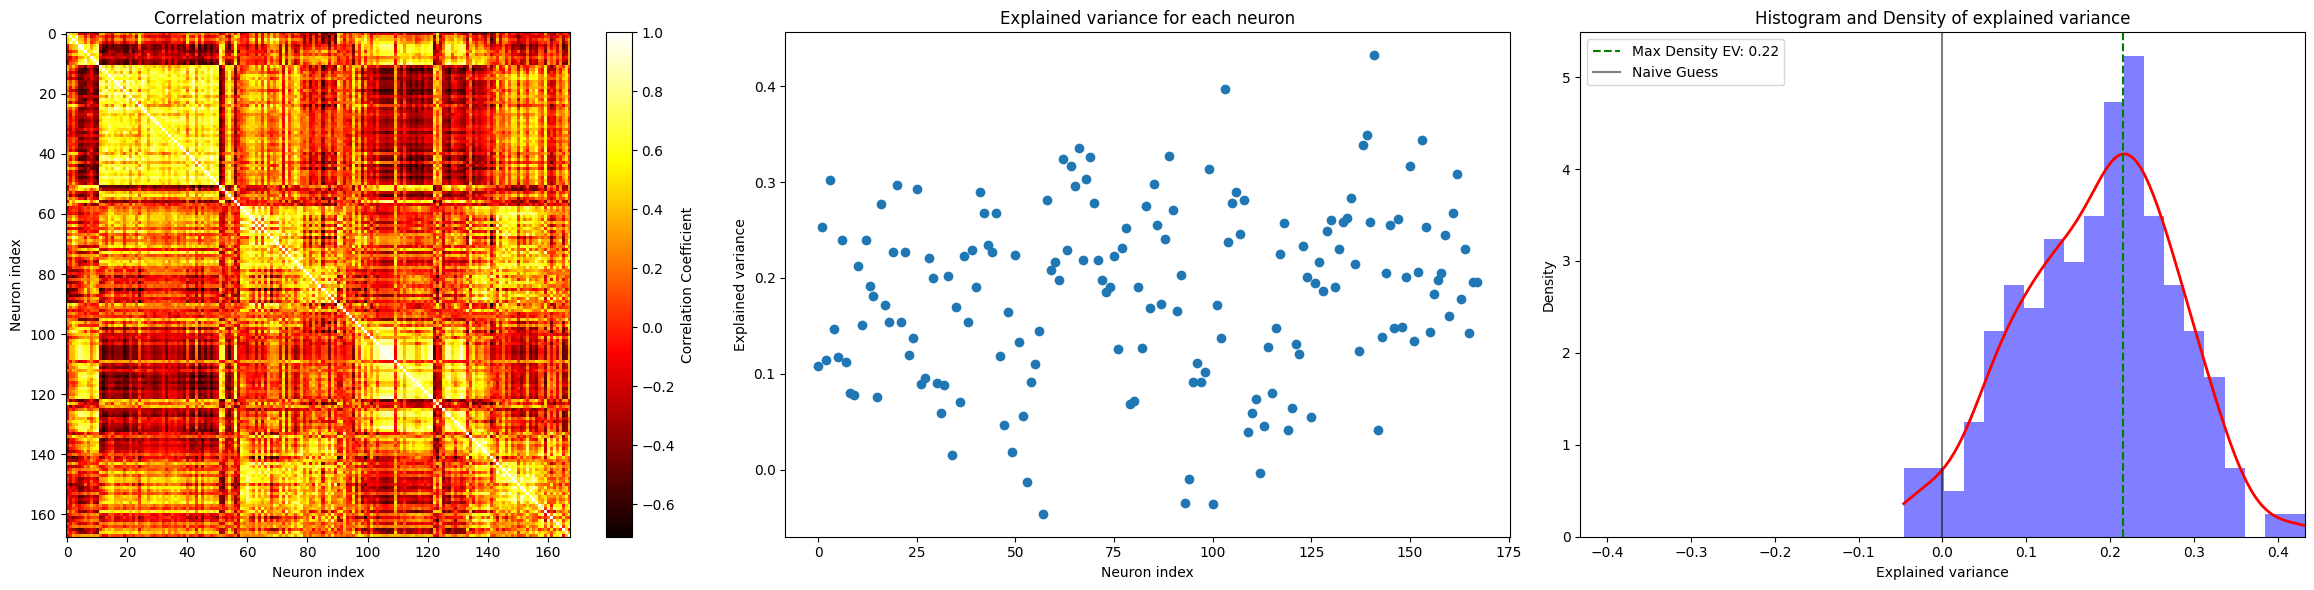

In [ ]:
# Loop over the rest of the layers
layer_pca_models = {}

alphas = np.logspace(0, 10, 200)
param_grid = {'alpha': alphas}

for layer_name in layer_map.keys():
    print(f"Processing layer: {layer_name}")
    layer_index = list(layer_map.keys()).index(layer_name)

    # 1. Extract test activations
    print(f"    Extracting activations...")
    layer_test_acts = activation_model.predict(X_test_prep, batch_size=32)[layer_index]
    layer_train_acts = activation_model.predict(X_train_prep, batch_size=32)[layer_index]
    flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)

    # 2. PCA transformation
    print(f"    Loading PCA model...")
    pca = joblib.load(f'pca_{layer_name}.pkl')
    test_pca = pca.transform(flat_test)
    train_pca = pca.transform(flat_train)

    # 3. Initialize and fit ridge regression
    print(f"    Fitting Ridge regression...")
    ridge = Ridge()
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='explained_variance')
    grid_search.fit(train_pca, spikes_train)

    # 4. Find the best alpha
    print(f"    Finding best alpha...")
    best_alpha = grid_search.best_params_['alpha']
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(train_pca, spikes_train)
    print('Best Alpha: {}'.format(best_alpha))

    # 5. Predict on test data using best alpha
    print(f"    Predicting on test data...")
    preds = ridge.predict(test_pca)
    predictions_train_ridge = ridge.predict(train_pca)
    ev = explained_variance_score(spikes_val, preds, multioutput='raw_values')
    mean_ev = ev.mean()
    print(f"{layer_name} → Mean Explained Variance: {mean_ev:.4f}")

    # 6. Store the explained variance for each layer in a dictionary
    print(f"    Storing results...")
    layer_pca_models[layer_name] = {
        'model': ridge,
        'explained_variance': mean_ev
    }

    # 7. Inspect the model
    print(f"    Inspecting results...")
    inspect_alphas(grid_search, alphas, layer_name)
    inspect_ridge(predictions_train_ridge, preds, spikes_val, layer_name)
    print()

#### Saving Ridge Model
Create and save the best ridge regression models for each layer

In [ ]:
# - Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
results_summary = {}

for layer_name in layer_pca_models.keys():
    print(f"\n--- Processing Layer: {layer_name} ---")
    layer_index = list(layer_map.keys()).index(layer_name)

    # 1. Extract test activations and flatten
    print(f"    Extracting test activations...")
    layer_test_acts = activation_model.predict(X_test_prep, batch_size=32)[layer_index]
    flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)

    # 2. Load PCA and transform test data
    print(f"    Loading PCA model...")
    pca = joblib.load(f'pca_{layer_name}.pkl')
    test_pca = pca.transform(flat_test)

    # 3. Load trained Ridge model
    print(f"    Loading Ridge model...")
    ridge_model = layer_pca_models[layer_name]['model']
    best_alpha = ridge_model.alpha

    # 4. Predict neural activity
    print(f"    Predicting neural activity...")
    preds = ridge_model.predict(test_pca)

    # 5. Compute explained variance (already stored, but recompute to confirm)
    print(f"    Computing explained variance...")
    ev = explained_variance_score(spikes_val, preds, multioutput='raw_values')
    mean_ev = ev.mean()

    # 6. Compute neuron-wise correlations (diagonal)
    print(f"    Computing neuron-wise correlations...")
    correlations = []
    for i in range(spikes_val.shape[1]):  # For each neuron
        corr = np.corrcoef(preds[:, i], spikes_val[:, i])[0, 1]
        correlations.append(corr)
    correlations = np.array(correlations)
    mean_corr = np.nanmean(correlations)  # In case of NaNs

    # 7. Store results
    print(f"    Storing results...")
    results_summary[layer_name] = {
        'best_alpha': best_alpha,
        'mean_explained_variance': mean_ev,
        'mean_correlation': mean_corr
    }

    # Print summary for this layer
    print(f"Best Alpha: {best_alpha}")
    print(f"Mean Explained Variance: {mean_ev:.4f}")
    print(f"Mean Neuron-wise Correlation: {mean_corr:.4f}\n")

# Final summary
print("\n=== Summary Across Layers ===")
for layer, stats in results_summary.items():
    print(f"{layer}: Alpha={stats['best_alpha']}, EV={stats['mean_explained_variance']:.4f}, Corr={stats['mean_correlation']:.4f}")



--- Processing Layer: conv1 ---
    Extracting test activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
    Loading PCA model...
    Loading Ridge model...
    Predicting neural activity...
    Computing explained variance...
    Computing neuron-wise correlations...
    Storing results...
Best Alpha: 8603464.416684508
Mean Explained Variance: 0.0900
Mean Neuron-wise Correlation: 0.2825


--- Processing Layer: layer1 ---
    Extracting test activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step
    Loading PCA model...
    Loading Ridge model...
    Predicting neural activity...
    Computing explained variance...
    Computing neuron-wise correlations...
    Storing results...
Best Alpha: 74881.03857590031
Mean Explained Variance: 0.2540
Mean Neuron-wise Correlation: 0.4887


--- Processing Layer: layer2 ---
    Extracting test activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step
    Loading PCA model...
    Loading Ridge model...
    Predicting neural activity...
    Computing exp

In [ ]:
def save_layer_results(results_summary, layer_pca_models, save_dir='ridge_results'):
    """
    Save Ridge models and metrics for each layer.
    
    Args:
        results_summary (dict): Dictionary containing metrics per layer.
        layer_pca_models (dict): Dictionary containing trained Ridge models.
        save_dir (str): Directory where to save the files.
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # 1. Save each Ridge model
    models_dir = os.path.join(save_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)

    for layer_name, data in layer_pca_models.items():
        model = data['model']
        joblib.dump(model, os.path.join(models_dir, f"ridge_{layer_name}.pkl"))

    print(f"✅ Saved Ridge models to: {models_dir}")

    # 2. Save metrics as JSON
    metrics_to_save = {}
    for layer, stats in results_summary.items():
        metrics_to_save[layer] = {
            'best_alpha': float(stats['best_alpha']),
            'mean_explained_variance': float(stats['mean_explained_variance']),
            'mean_correlation': float(stats['mean_correlation'])
        }

    with open(os.path.join(save_dir, 'metrics_summary.json'), 'w') as f:
        json.dump(metrics_to_save, f, indent=4)

    print(f"✅ Saved metrics summary to: {os.path.join(save_dir, 'metrics_summary.json')}")

    print("🎉 All results saved successfully!")

save_layer_results(results_summary, layer_pca_models, save_dir='my_neural_prediction_results')

✅ Saved Ridge models to: my_neural_prediction_results/models
✅ Saved metrics summary to: my_neural_prediction_results/metrics_summary.json
🎉 All results saved successfully!


#### Load the layers and check out the results

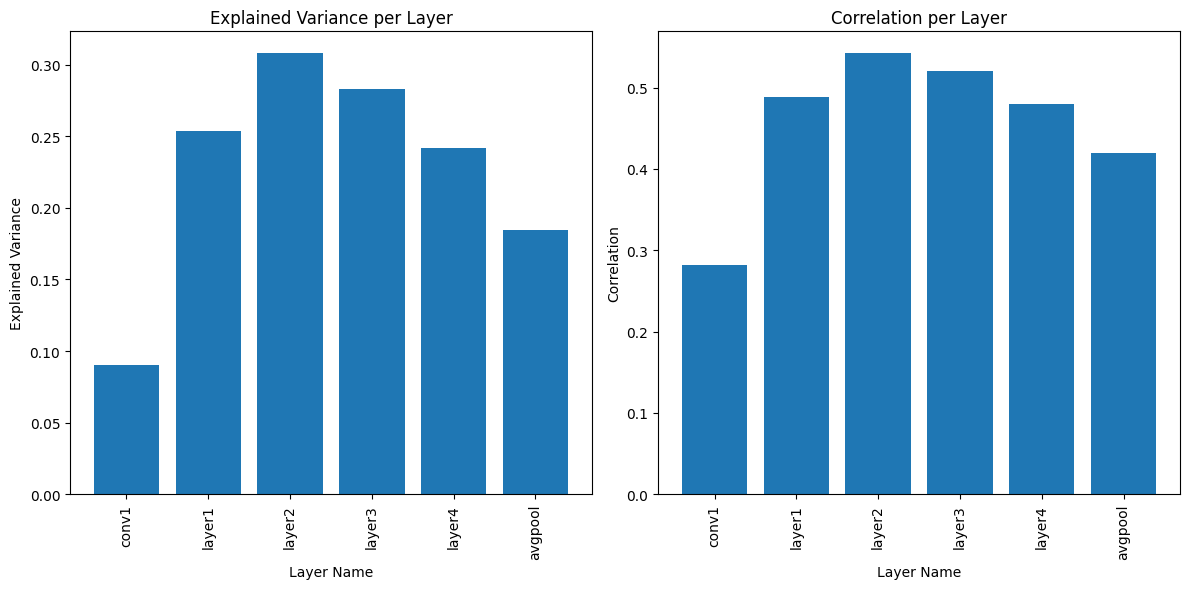

In [15]:
# Load the results

# for layer two for example
# ridge_layer2 = joblib.load('my_neural_prediction_results/models/ridge_layer2.pkl')

# with open('my_neural_prediction_results/metrics_summary.json', 'r') as f:
#     metrics = json.load(f)
# print(metrics['layer2'])

# for each layer, plot the explained variance and the correlation in a histogram fashion to see how the distribution looks like
# load the json file of the metrics
with open('my_neural_prediction_results/metrics_summary.json', 'r') as f:
    metrics = json.load(f)

metrics
# for each layer in the metrics, load all the explained variance, and plot a bar plot of the explained variance and the correlation
# create a list of the explained variance and the correlation for each layer
# create a list of the layer names
layer_names = []
explained_variances = []
correlations = []
for layer, stats in metrics.items():
    layer_names.append(layer)
    explained_variances.append(stats['mean_explained_variance'])
    correlations.append(stats['mean_correlation'])

# plot the explained variance and the correlation in two separate bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(layer_names, explained_variances)
plt.xticks(rotation=90)
plt.title('Explained Variance per Layer')
plt.ylabel('Explained Variance')
plt.xlabel('Layer Name')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.bar(layer_names, correlations)
plt.xticks(rotation=90)
plt.title('Correlation per Layer')
plt.ylabel('Correlation')
plt.xlabel('Layer Name')
plt.tight_layout()
plt.show()

### Random Task-Driven Model
Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

#### Model Import
Needs to be ran as we will import the model with random initialized weights

In [ ]:
# Randomly initialized ResNet50
randomly_initialized_model = ResNet50(weights=None, include_top=True, input_shape=(224, 224, 3))

# Map their conceptual layer names to Keras layer names
layer_map = {
    'conv1': 'conv1_conv',
    'layer1': 'conv2_block3_out',
    'layer2': 'conv3_block4_out',
    'layer3': 'conv4_block6_out',
    'layer4': 'conv5_block3_out',
    'avgpool': 'avg_pool'
}
activation_model_randomly_init = Model(inputs=randomly_initialized_model.input, 
                         outputs=[randomly_initialized_model.get_layer(name).output for name in layer_map.values()])

X_train_prep = preprocess_input(stimulus_train)
X_test_prep = preprocess_input(stimulus_val)

X_train_prep = np.reshape(X_train_prep, (X_train_prep.shape[0], img_size, img_size, n_channels))
X_test_prep = np.reshape(X_test_prep, (X_test_prep.shape[0], img_size, img_size, n_channels))

#### PCA Inicialization
Only run if you haven+t done it before

In [ ]:
train_pca_activations = {}

n_components = 1000  # Number of PCA components
for i, (logical_name, keras_name) in enumerate(layer_map.items()):
    print(f"Processing layer: {logical_name}")
    
    # Extract activations
    layer_train_acts = activation_model_randomly_init.predict(X_train_prep)[i]
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)

    # Compute PCA
    pca = PCA(n_components=n_components)
    train_pca = pca.fit_transform(flat_train)

    # Save PCA & scaler
    joblib.dump(pca, f'pca_{logical_name}_randomly_inits.pkl')

    # Store projected features
    train_pca_activations[logical_name] = train_pca

Processing layer: conv1
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step
Processing layer: layer1
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step
Processing layer: layer2
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step
Processing layer: layer3
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step
Processing layer: layer4
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step
Processing layer: avgpool
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step


#### Loop over layers

Processing layer: conv1
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 212145.1784910632
    Predicting on test data...
conv1 → Mean Explained Variance: 0.0921
    Storing results...
    Inspecting results...


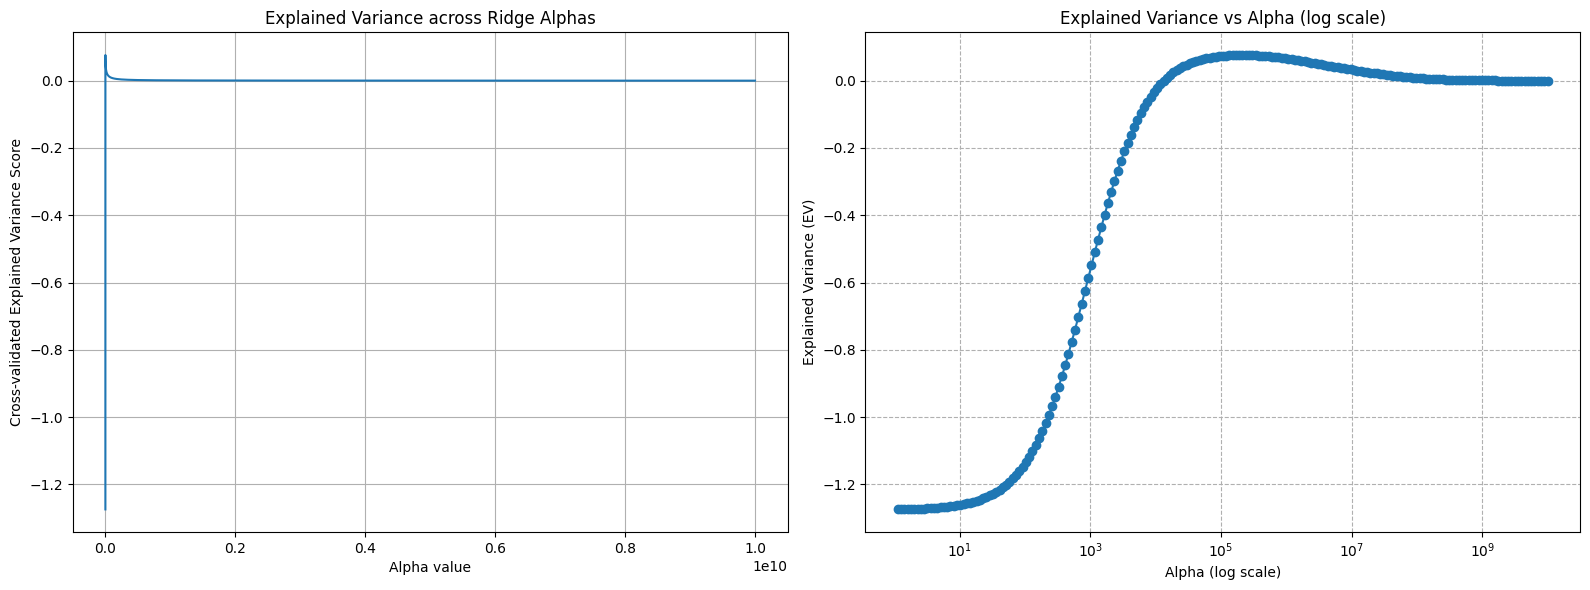

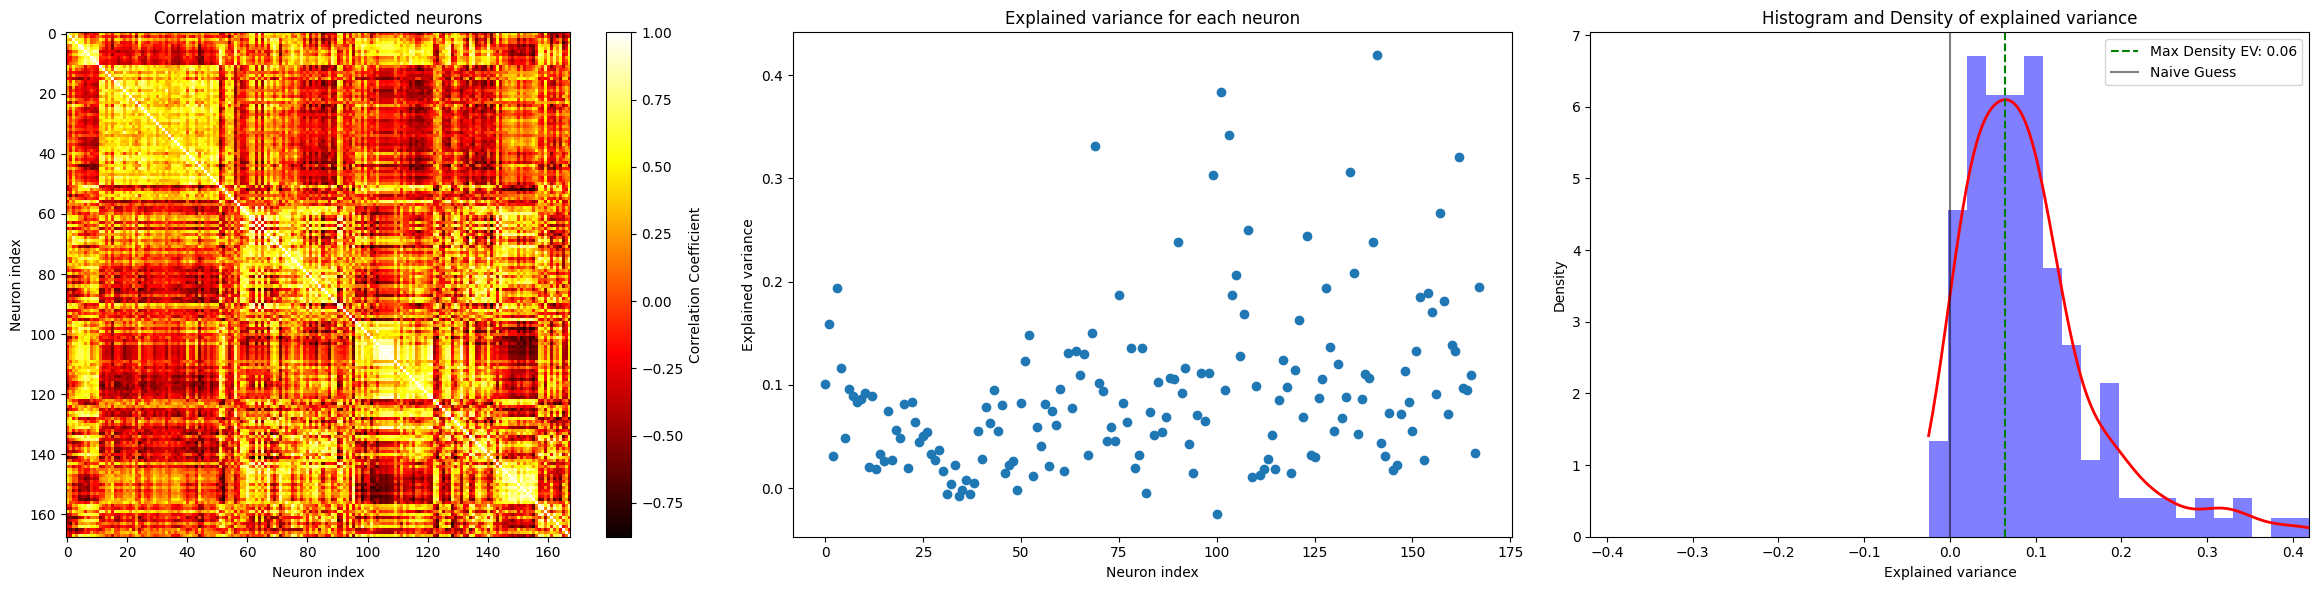


Processing layer: layer1
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 3696.9127071950284
    Predicting on test data...
layer1 → Mean Explained Variance: 0.2258
    Storing results...
    Inspecting results...


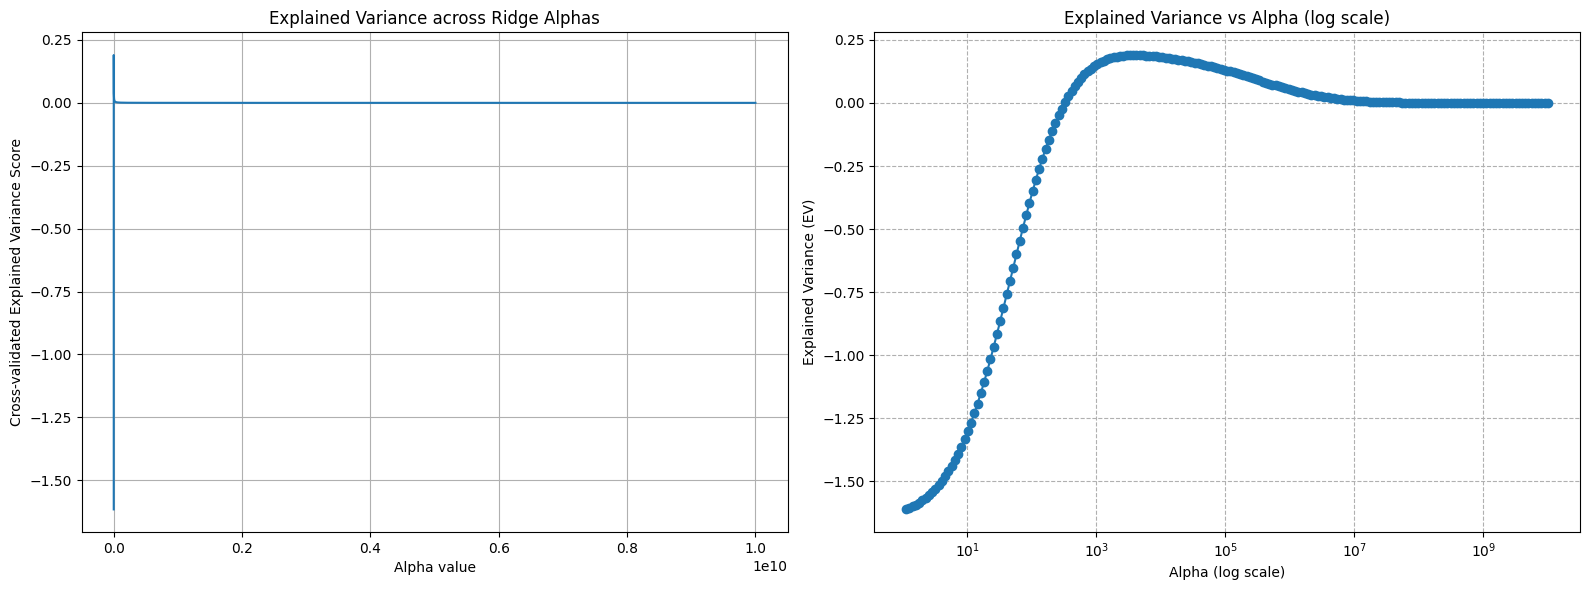

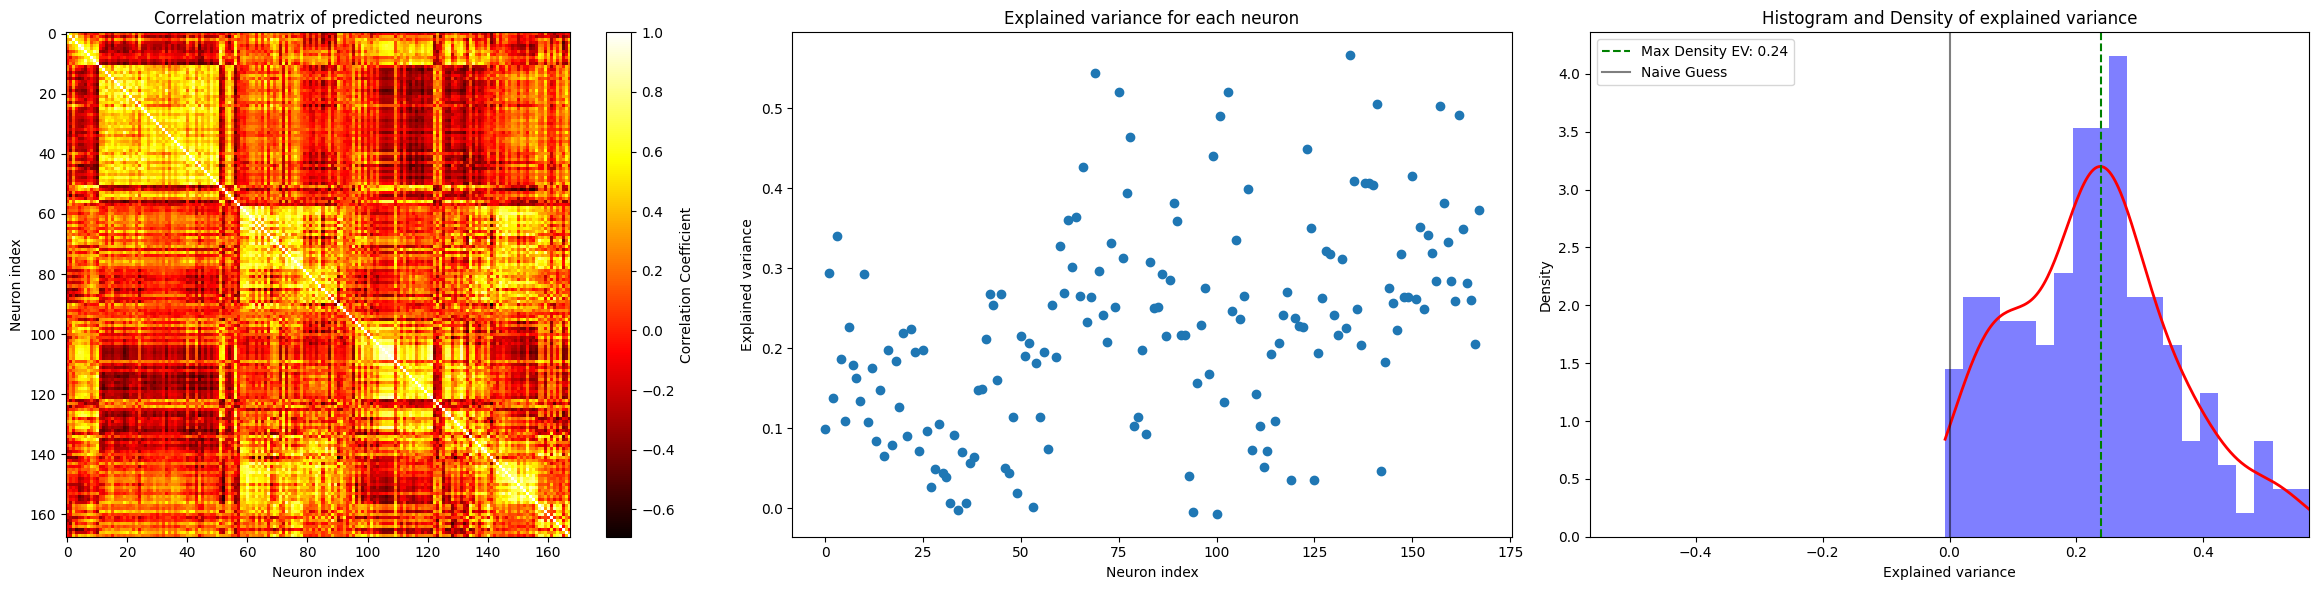


Processing layer: layer2
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 580.5225516094902
    Predicting on test data...
layer2 → Mean Explained Variance: 0.2353
    Storing results...
    Inspecting results...


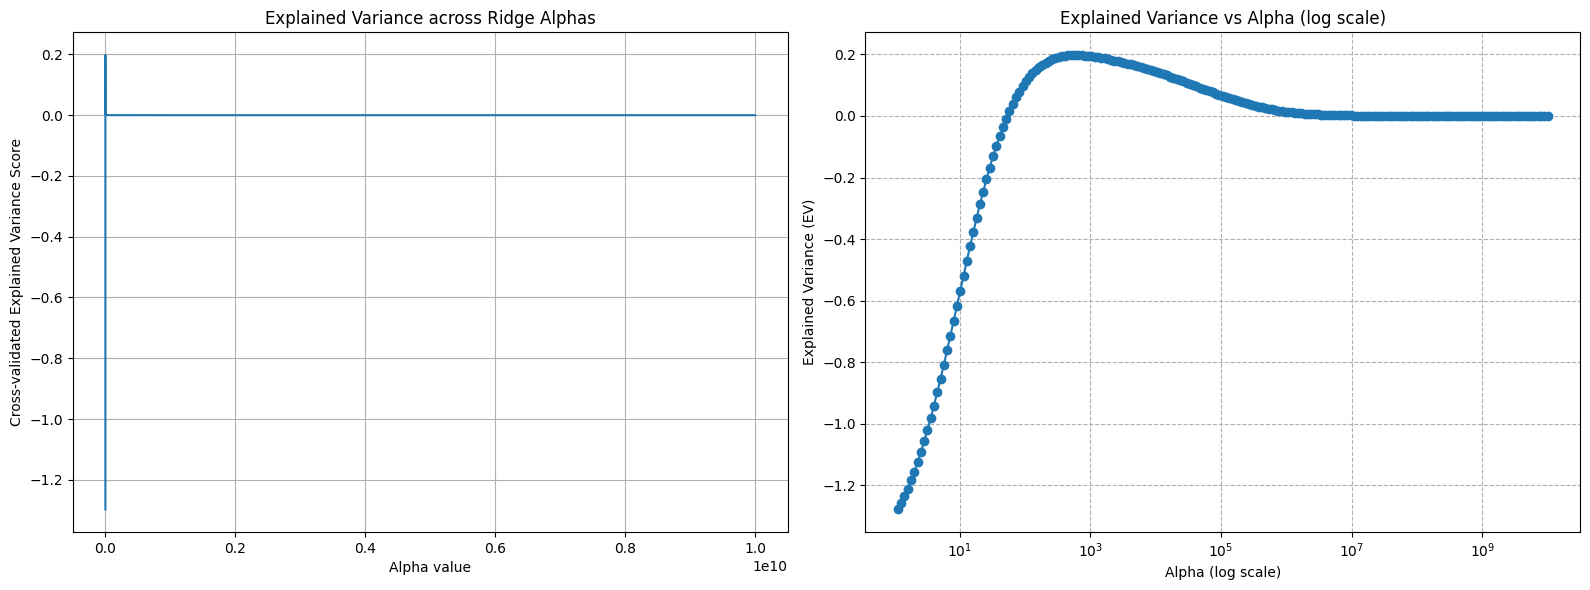

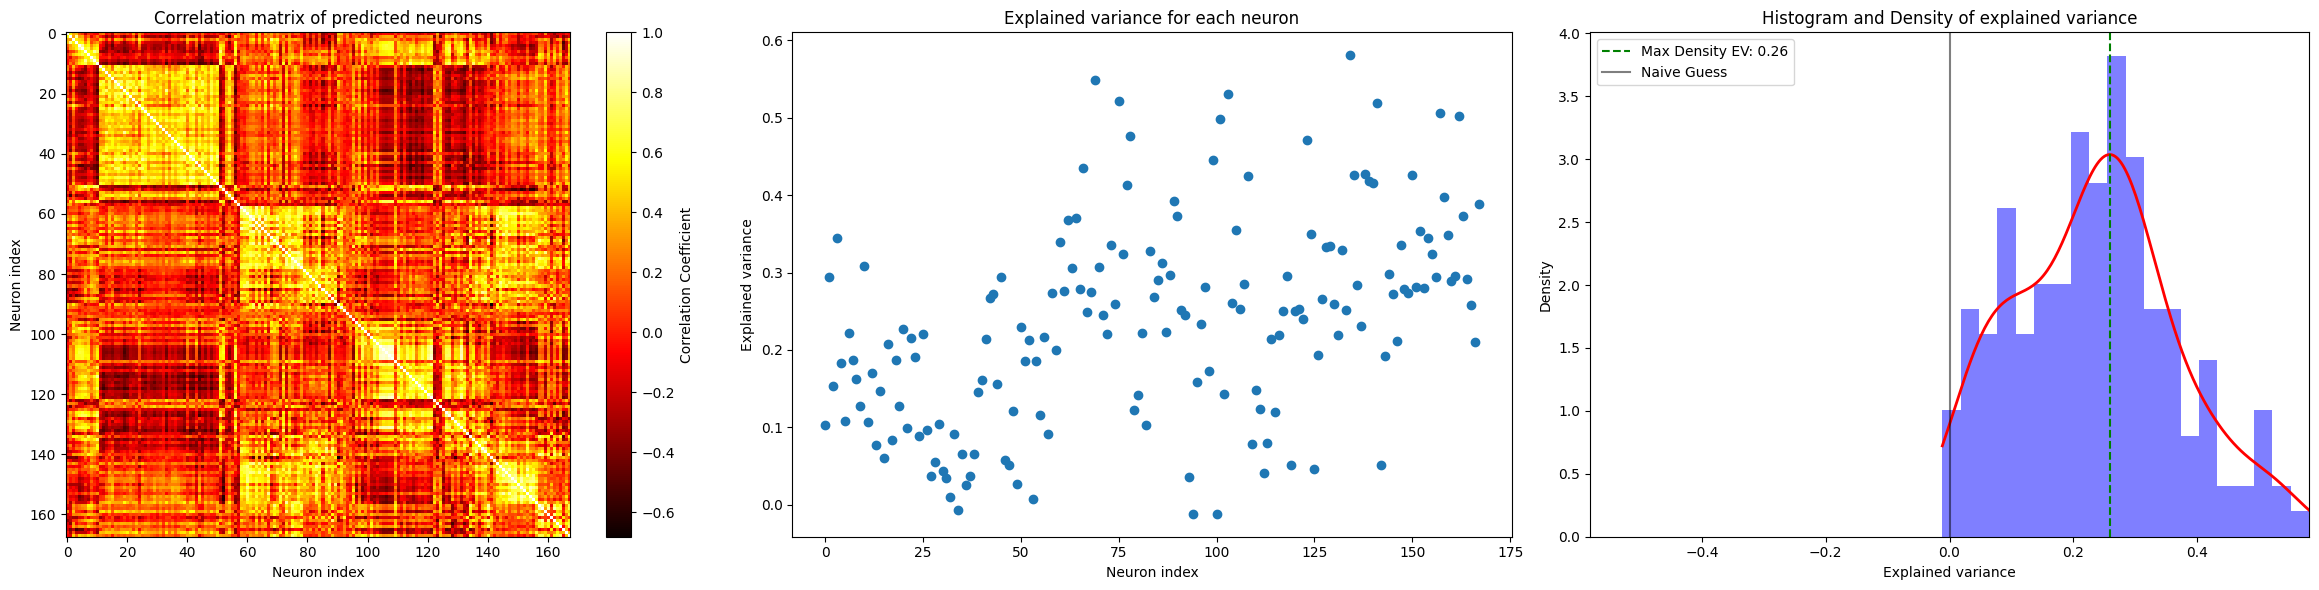


Processing layer: layer3
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 114.89510001873097
    Predicting on test data...
layer3 → Mean Explained Variance: 0.2288
    Storing results...
    Inspecting results...


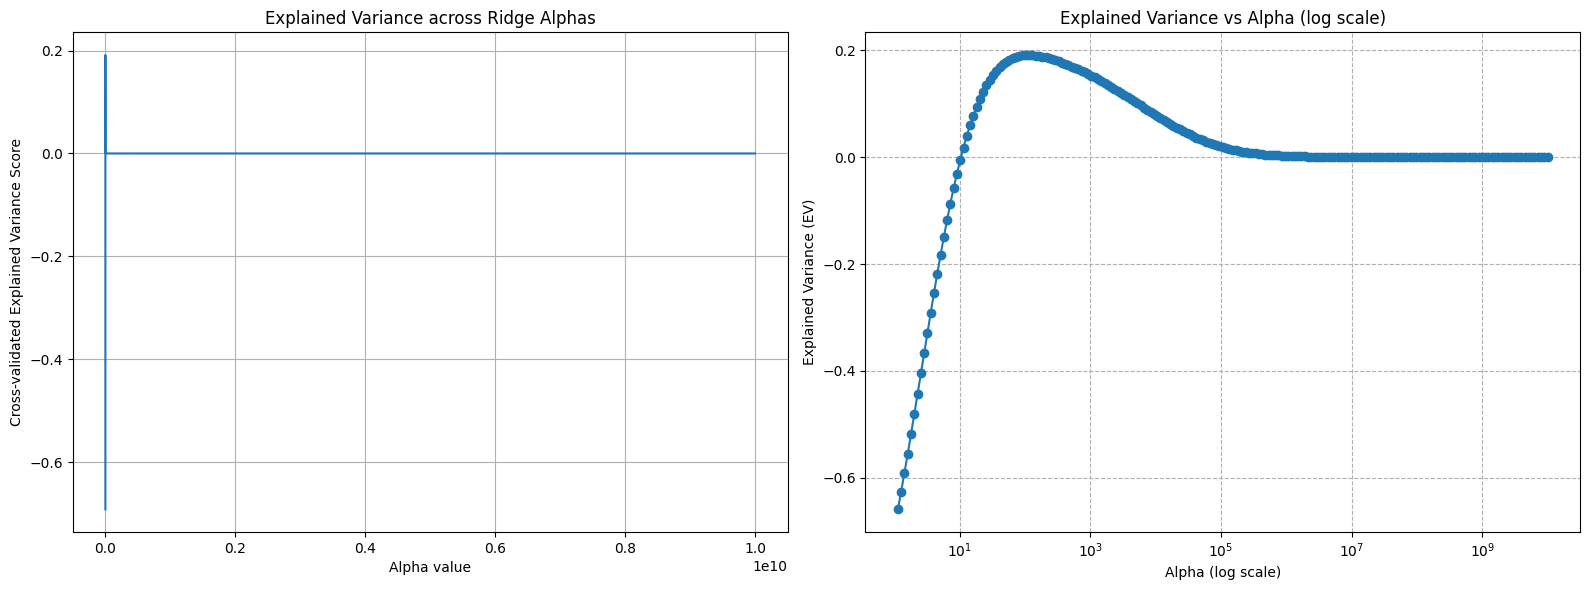

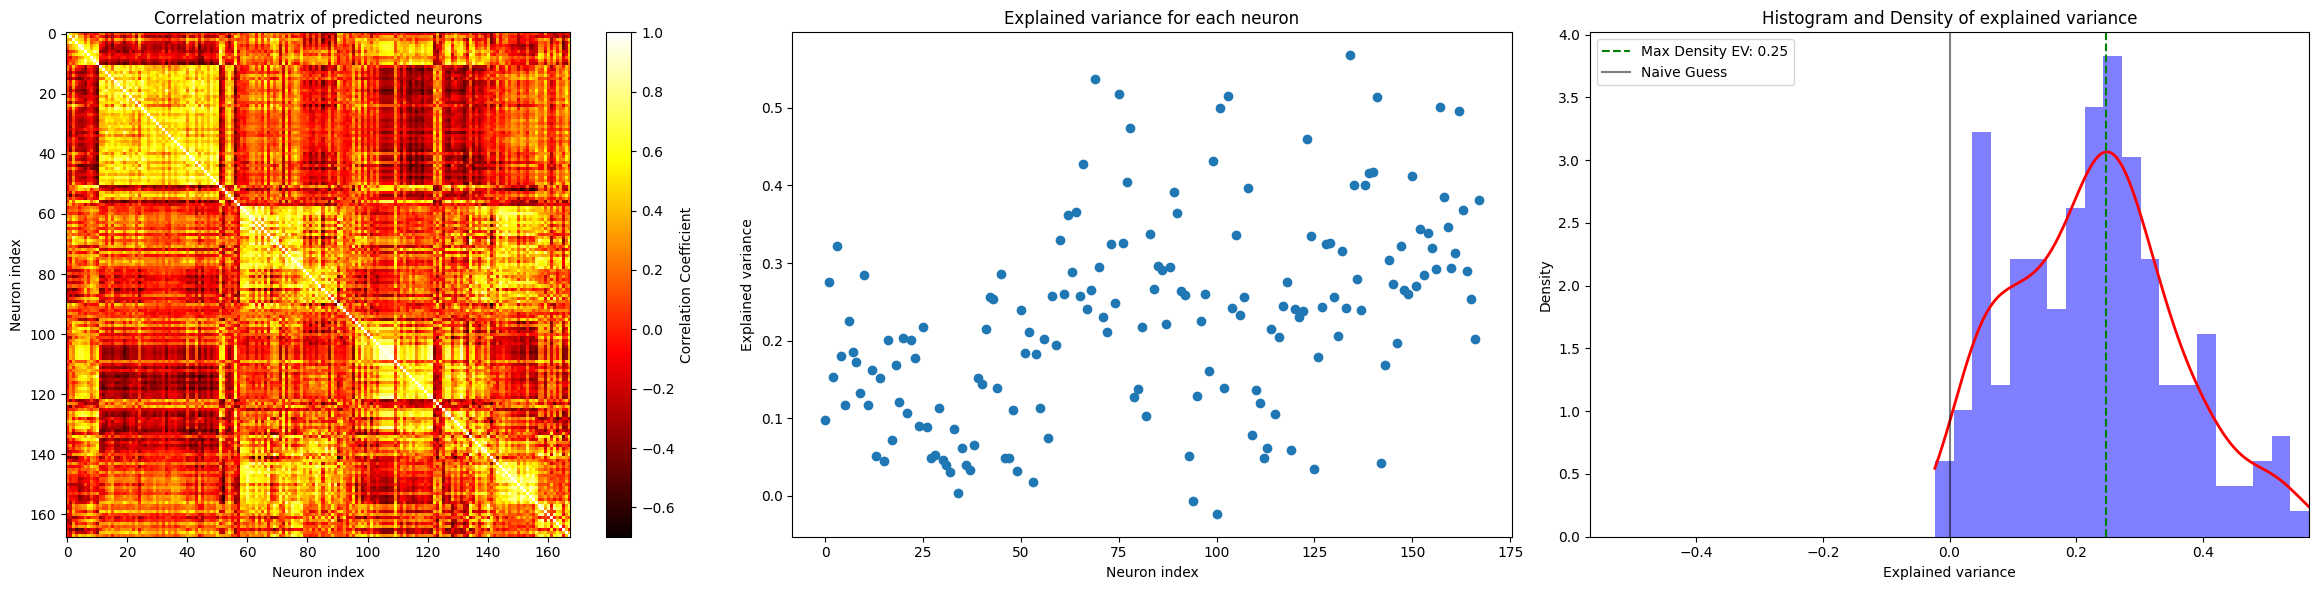


Processing layer: layer4
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 22.739657523579286
    Predicting on test data...
layer4 → Mean Explained Variance: 0.2217
    Storing results...
    Inspecting results...


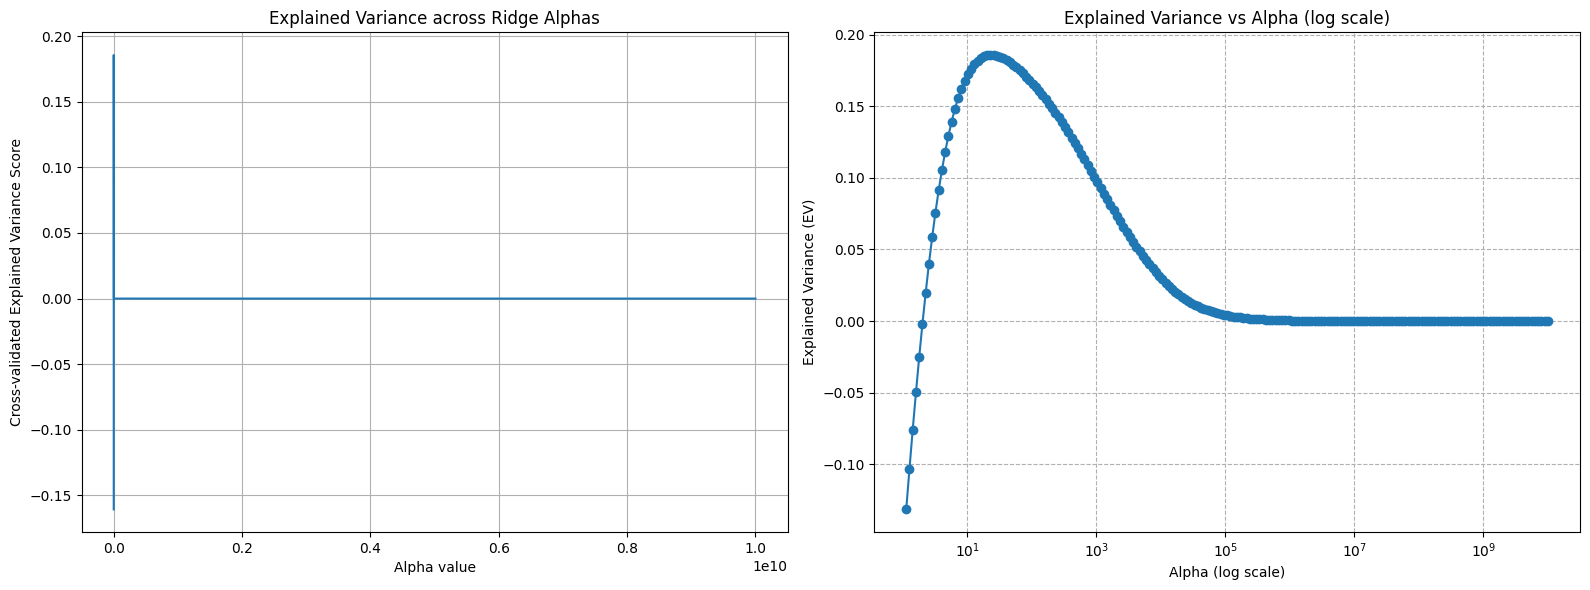

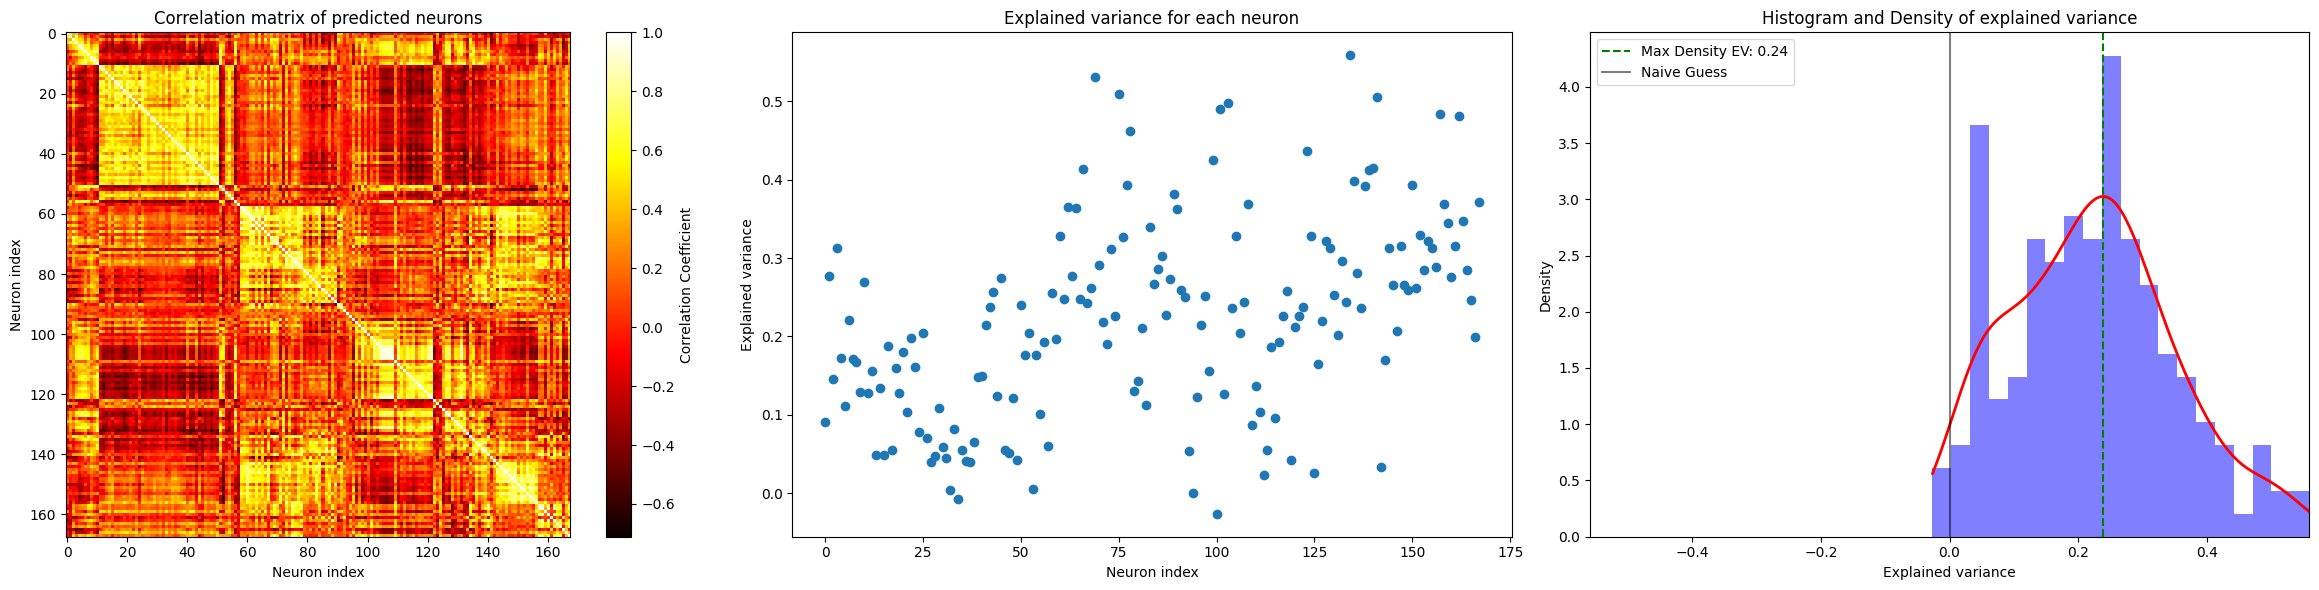


Processing layer: avgpool
    Extracting activations...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step
    Loading PCA model...
    Fitting Ridge regression...
    Finding best alpha...
Best Alpha: 1.0
    Predicting on test data...
avgpool → Mean Explained Variance: 0.0712
    Storing results...
    Inspecting results...


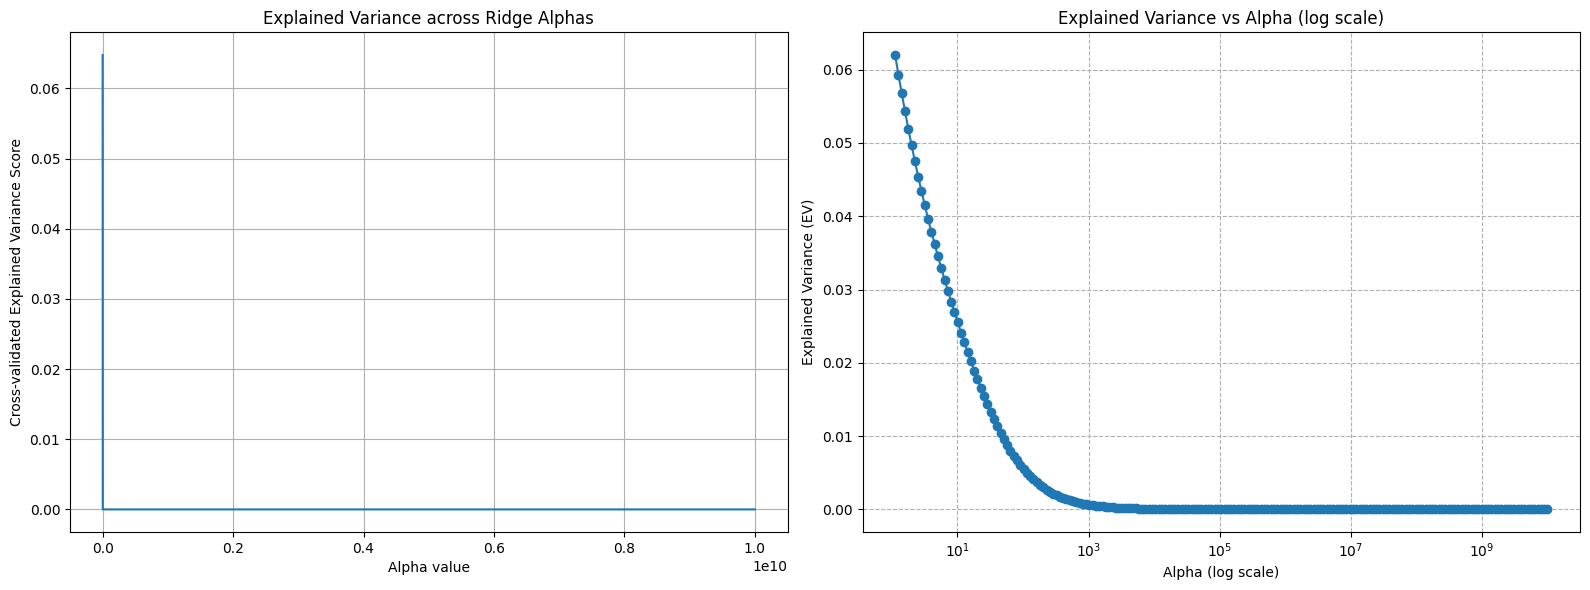

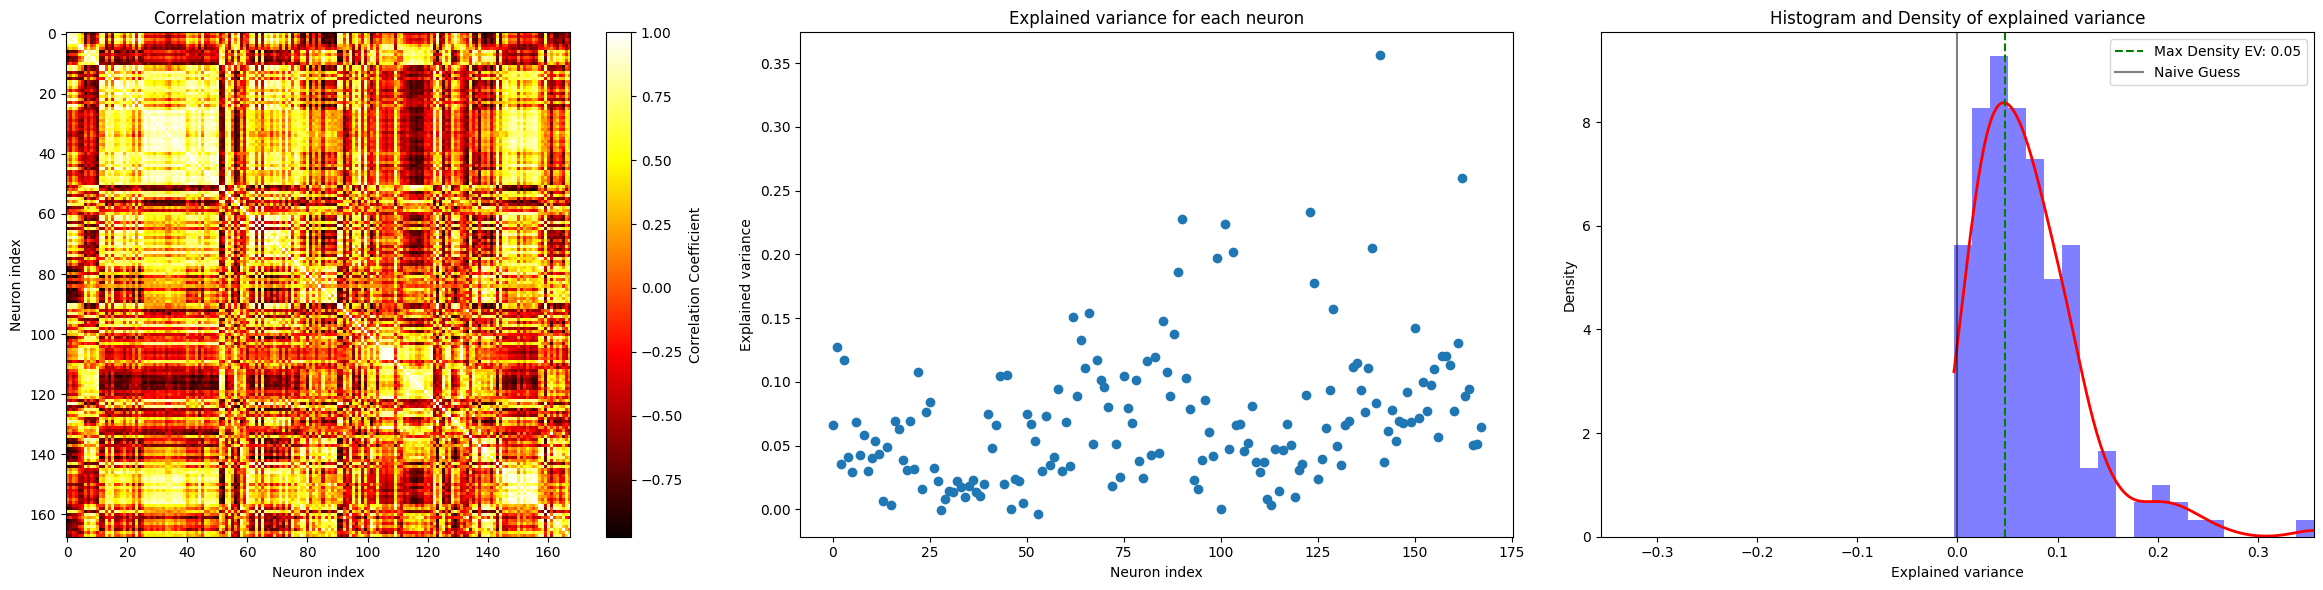

In [ ]:
# loop over the rest of the layers
layer_pca_models_rand_int = {}

alphas = np.logspace(0, 10, 200)
param_grid = {'alpha': alphas}

for layer_name in layer_map.keys():

    print(f"Processing layer: {layer_name}")
    layer_index = list(layer_map.keys()).index(layer_name)

    # 1. Extract test activations
    print(f"    Extracting activations...")
    layer_test_acts = activation_model_randomly_init.predict(X_test_prep, batch_size=32)[layer_index]
    layer_train_acts = activation_model_randomly_init.predict(X_train_prep, batch_size=32)[layer_index]
    flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)

    # 2. PCA transformation
    print(f"    Loading PCA model...")
    pca = joblib.load(f'pca_{layer_name}_randomly_inits.pkl')
    test_pca = pca.transform(flat_test)
    train_pca = pca.transform(flat_train)

    # 3. Initialize and fit ridge regression
    print(f"    Fitting Ridge regression...")
    ridge = Ridge()
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='explained_variance')
    grid_search.fit(train_pca, spikes_train)

    # 4. Find the best alpha
    print(f"    Finding best alpha...")
    best_alpha = grid_search.best_params_['alpha']
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(train_pca, spikes_train)
    print('Best Alpha: {}'.format(best_alpha))

    # 5. Predict on test data using best alpha
    print(f"    Predicting on test data...")
    preds = ridge.predict(test_pca)
    predictions_train_ridge = ridge.predict(train_pca)
    ev = explained_variance_score(spikes_val, preds, multioutput='raw_values')
    mean_ev = ev.mean()
    print(f"{layer_name} → Mean Explained Variance: {mean_ev:.4f}")

    # 6. Store the explained variance for each layer in a dictionary
    print(f"    Storing results...")
    layer_pca_models_rand_int[layer_name] = {
        'model': ridge,
        'explained_variance': mean_ev
    }

    # 7. Inspect the model
    print(f"    Inspecting results...")
    inspect_alphas(grid_search, alphas, layer_name)
    inspect_ridge(predictions_train_ridge, preds, spikes_val, layer_name)
    print()

#### Saving Ridge Model
Create and save the best ridge regression models for each layer

In [ ]:
# - Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
results_summary_ran_int = {}

for layer_name in layer_pca_models_rand_int.keys():
    print(f"\n--- Processing Layer: {layer_name} ---")
    layer_index = list(layer_map.keys()).index(layer_name)

    # 1. Extract test activations and flatten
    layer_test_acts = activation_model_randomly_init.predict(X_test_prep, batch_size=32)[layer_index]
    flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)

    # 2. Load PCA and transform test data
    pca = joblib.load(f'pca_{layer_name}_randomly_inits.pkl')
    test_pca = pca.transform(flat_test)

    # 3. Load trained Ridge model
    ridge_model = layer_pca_models_rand_int[layer_name]['model']
    best_alpha = ridge_model.alpha

    # 4. Predict neural activity
    preds = ridge_model.predict(test_pca)

    # 5. Compute explained variance (already stored, but recompute to confirm)
    ev = explained_variance_score(spikes_val, preds, multioutput='raw_values')
    mean_ev = ev.mean()

    # 6. Compute neuron-wise correlations (diagonal)
    correlations = []
    for i in range(spikes_val.shape[1]):  # For each neuron
        corr = np.corrcoef(preds[:, i], spikes_val[:, i])[0, 1]
        correlations.append(corr)
    correlations = np.array(correlations)
    mean_corr = np.nanmean(correlations)  # In case of NaNs

    # 7. Store results
    results_summary_ran_int[layer_name] = {
        'best_alpha': best_alpha,
        'mean_explained_variance': mean_ev,
        'mean_correlation': mean_corr
    }

    # Print summary for this layer
    print(f"Best Alpha: {best_alpha}")
    print(f"Mean Explained Variance: {mean_ev:.4f}")
    print(f"Mean Neuron-wise Correlation: {mean_corr:.4f}\n")

# Final summary
print("\n=== Summary Across Layers ===")
for layer, stats in results_summary_ran_int.items():
    print(f"{layer}: Alpha={stats['best_alpha']}, EV={stats['mean_explained_variance']:.4f}, Corr={stats['mean_correlation']:.4f}")


--- Processing Layer: conv1 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Best Alpha: 212145.1784910632
Mean Explained Variance: 0.0921
Mean Neuron-wise Correlation: 0.2851


--- Processing Layer: layer1 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Best Alpha: 3696.9127071950284
Mean Explained Variance: 0.2258
Mean Neuron-wise Correlation: 0.4578


--- Processing Layer: layer2 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step
Best Alpha: 580.5225516094902
Mean Explained Variance: 0.2353
Mean Neuron-wise Correlation: 0.4678


--- Processing Layer: layer3 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Best Alpha: 114.89510001873097
Mean Explained Variance: 0.2288
Mean Neuron-wise Correlation: 0.4616


--- Processing Layer: layer4 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Best Alpha: 22.739657523579286
Mean Explained Variance: 0.2217
Mean Neuron-wise Correlation: 0.4539


--- Processing Layer: avgpool ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Best Alpha: 1.0
Mean Explained Variance: 0.0712
Mean Neuron

In [ ]:
save_layer_results(results_summary_ran_int, layer_pca_models_rand_int, save_dir='my_neural_prediction_results_randomly_init')

✅ Saved Ridge models to: my_neural_prediction_results_randomly_init/models
✅ Saved metrics summary to: my_neural_prediction_results_randomly_init/metrics_summary.json
🎉 All results saved successfully!


#### Load the Layers and Check Results
To avoid running the code everytime you want to analyse the results just load the model here

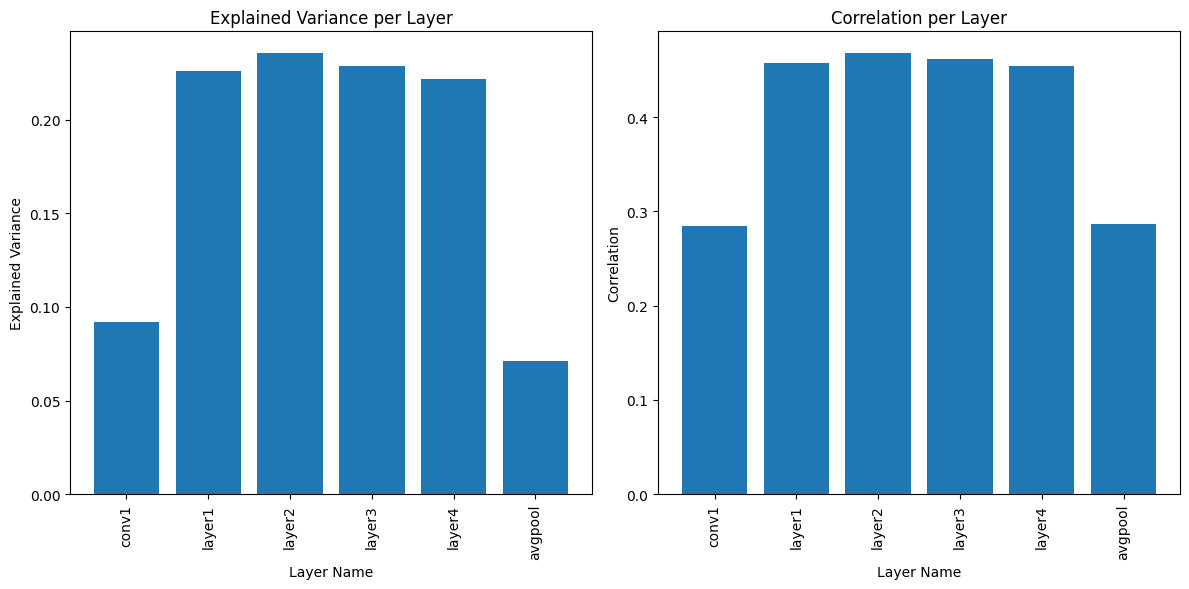

In [16]:
with open('my_neural_prediction_results_randomly_init/metrics_summary.json', 'r') as f:
    metrics = json.load(f)

# for each layer in the metrics, load all the explained variance, and plot a bar plot of the explained variance and the correlation
# create a list of the explained variance and the correlation for each layer
# create a list of the layer names

layer_names = []
explained_variances = []
correlations = []
for layer, stats in metrics.items():
    layer_names.append(layer)
    explained_variances.append(stats['mean_explained_variance'])
    correlations.append(stats['mean_correlation'])

# Plot the explained variance and the correlation in two separate bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(layer_names, explained_variances)
plt.xticks(rotation=90)
plt.title('Explained Variance per Layer')
plt.ylabel('Explained Variance')
plt.xlabel('Layer Name')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.bar(layer_names, correlations)
plt.xticks(rotation=90)
plt.title('Correlation per Layer')
plt.ylabel('Correlation')
plt.xlabel('Layer Name')
plt.tight_layout()
plt.show()


#### In summary, we note two particular things:

1. The randomly initialized weights of the model performs worse in terms of explained variance and correlation. This can definitely be explained by the fine tuning and the fact that the pre-trained resnet50 is tuned to the task of predicting images - hence being further tuned towards the task-based method.
We do note, however, a negative explained variance on the first layer. And this can be simply due to the definition of the explained variance, where we are performing $\textit{worse}$ than if we are choosing at random. 
Also, it is because we measure the explained variance based on the train set and measure the EV on the validation set - in the same way that an $R^2$ value can be negative

2. The explained variance increases as we go deeper into the model

    $(\textbf{conv}_1 < \textbf{layer}_1 < \textbf{layer}_2)$

    Which can be explained by the fact that more information can be represented as we go deeper into the model. However, as we go further deep into the layers, information gets lost due to the depth, which can possibly explain the decrease in the explained variance as we go too far into the layers themselves



### Compare Train and Random Task-Driven Model

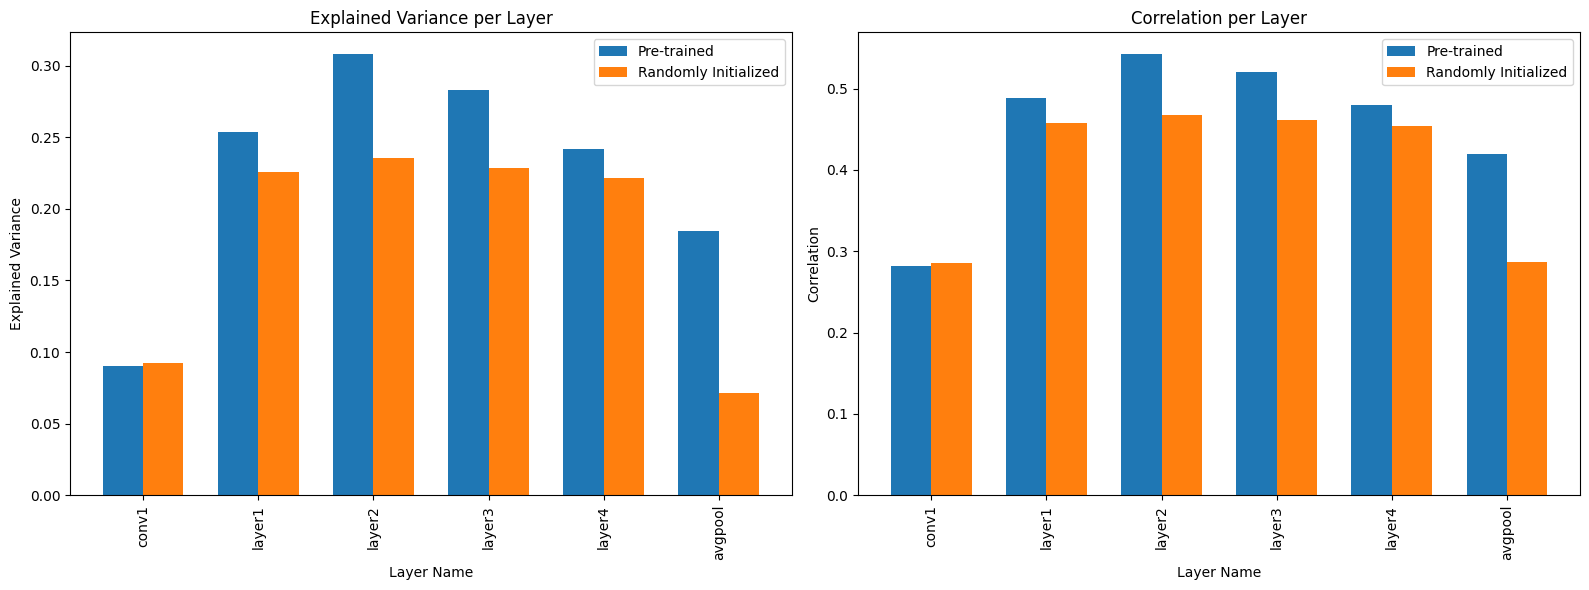

In [17]:
import json
import numpy as np

import matplotlib.pyplot as plt

# Load pre-trained metrics
with open('my_neural_prediction_results/metrics_summary.json', 'r') as f:
    metrics_pretrained = json.load(f)

# Load randomly initialized metrics
with open('my_neural_prediction_results_randomly_init/metrics_summary.json', 'r') as f:
    metrics_random = json.load(f)

# Get the layer names (assumed identical order)
layer_names = list(metrics_pretrained.keys())

# Extract explained variance and correlation for both models
explained_variance_pt = [metrics_pretrained[layer]['mean_explained_variance'] for layer in layer_names]
correlation_pt       = [metrics_pretrained[layer]['mean_correlation'] for layer in layer_names]

explained_variance_rand = [metrics_random[layer]['mean_explained_variance'] for layer in layer_names]
correlation_rand        = [metrics_random[layer]['mean_correlation'] for layer in layer_names]

# Create x positions for grouped bar charts
x = np.arange(len(layer_names))
width = 0.35  # width of the bars

# Create two subplots for Explained Variance and Correlation in one figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Explained Variance subplot
axs[0].bar(x - width/2, explained_variance_pt, width, label='Pre-trained')
axs[0].bar(x + width/2, explained_variance_rand, width, label='Randomly Initialized')
axs[0].set_xticks(x)
axs[0].set_xticklabels(layer_names, rotation=90)
axs[0].set_ylabel('Explained Variance')
axs[0].set_xlabel('Layer Name')
axs[0].set_title('Explained Variance per Layer')
axs[0].legend()

# Correlation subplot
axs[1].bar(x - width/2, correlation_pt, width, label='Pre-trained')
axs[1].bar(x + width/2, correlation_rand, width, label='Randomly Initialized')
axs[1].set_xticks(x)
axs[1].set_xticklabels(layer_names, rotation=90)
axs[1].set_ylabel('Correlation')
axs[1].set_xlabel('Layer Name')
axs[1].set_title('Correlation per Layer')
axs[1].legend()

plt.tight_layout()
plt.show()

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [6]:
import sys
#!{sys.executable} -m pip install gdown h5py

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)

## Load the Data

In [7]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [8]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [9]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!nvidia-smi

Wed May  7 12:45:24 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   39C    P0              25W / 250W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
### Here your code
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import r2_score, explained_variance_score

print(torch.cuda.is_available())  # True if GPU with CUDA is available
print(torch.cuda.device_count())
print(torch.cuda.current_device()) 
print(torch.cuda.get_device_name(0))

True
1
0
Tesla V100-PCIE-32GB


In [11]:
class CNN(nn.Module):
    def __init__(self, height, width, output_n):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, output_n)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return self.fc2(x)

In [12]:
class NeuralDataset(Dataset):
    def __init__(self, stimuli, spikes):
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32)
        self.spikes = torch.tensor(spikes, dtype=torch.float32)

    def __len__(self):
        return len(self.stimuli)
    
    def __getitem__(self, idx):
        return self.stimuli[idx], self.spikes[idx]
    
def get_dataloaders(batch_size, stimulus_train, spikes_train, stimulus_val, spikes_val):
    train_set = NeuralDataset(stimulus_train, spikes_train)
    val_set = NeuralDataset(stimulus_val, spikes_val)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [13]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for stimuli, spikes in train_loader:
            stimuli = stimuli.to(device)
            spikes = spikes.to(device)
            optimizer.zero_grad()
            outputs = model(stimuli)
            loss = criterion(outputs, spikes)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader):.4f}")

In [14]:
from scipy.stats import gaussian_kde

def inspect_ridge(predictions_train_ridge, predictions_val_ridge, spikes_val, name):
    # Correlate the neurons of the model with each other and plot the correlation matrix
    correlation_matrix = np.corrcoef(predictions_train_ridge.T)

    # Create the 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # --- Subplot 1: Correlation matrix ---
    im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Correlation Coefficient')
    axes[0].set_title('Correlation matrix of predicted neurons')
    axes[0].set_xlabel('Neuron index')
    axes[0].set_ylabel('Neuron index')

    # --- Subplot 2: Explained variance scatter ---
    ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_ridge[:, i]) for i in range(n_neurons)]
    axes[1].scatter(range(n_neurons), ev_scores)
    axes[1].set_xlabel('Neuron index')
    axes[1].set_ylabel('Explained variance')
    axes[1].set_title('Explained variance for each neuron')

    # --- Subplot 3: Histogram + density of explained variance ---
    axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
    density = gaussian_kde(ev_scores)
    x = np.linspace(min(ev_scores), max(ev_scores), 200)
    most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
    axes[2].plot(x, density(x), 'r', linewidth=2)
    max_density_val = x[np.argmax(density(x))]
    axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
    axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
    axes[2].set_xlabel('Explained variance')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Histogram and Density of explained variance')
    axes[2].set_xlim(-most_extreme, most_extreme)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(f'ridge_regression_analysis_{name}.png')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNN(height=img_size, width=img_size, output_n=n_neurons)

model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader, val_loader = get_dataloaders(16, stimulus_train, spikes_train, stimulus_val, spikes_val)

train_model(model, train_loader, criterion, optimizer, device, num_epochs=200)

torch.save(model.state_dict(), 'cnn_w7.pt')

cuda
Epoch 1, Training Loss: 0.1345
Epoch 2, Training Loss: 0.1327
Epoch 3, Training Loss: 0.1320
Epoch 4, Training Loss: 0.1310
Epoch 5, Training Loss: 0.1304
Epoch 6, Training Loss: 0.1298
Epoch 7, Training Loss: 0.1293
Epoch 8, Training Loss: 0.1286
Epoch 9, Training Loss: 0.1279
Epoch 10, Training Loss: 0.1266
Epoch 11, Training Loss: 0.1254
Epoch 12, Training Loss: 0.1246
Epoch 13, Training Loss: 0.1233
Epoch 14, Training Loss: 0.1225
Epoch 15, Training Loss: 0.1221
Epoch 16, Training Loss: 0.1215
Epoch 17, Training Loss: 0.1206
Epoch 18, Training Loss: 0.1205
Epoch 19, Training Loss: 0.1198
Epoch 20, Training Loss: 0.1192
Epoch 21, Training Loss: 0.1186
Epoch 22, Training Loss: 0.1181
Epoch 23, Training Loss: 0.1177
Epoch 24, Training Loss: 0.1173
Epoch 25, Training Loss: 0.1166
Epoch 26, Training Loss: 0.1162
Epoch 27, Training Loss: 0.1159
Epoch 28, Training Loss: 0.1153
Epoch 29, Training Loss: 0.1151
Epoch 30, Training Loss: 0.1149
Epoch 31, Training Loss: 0.1143
Epoch 32, Tr

In [17]:
def evaluate_model(model, train_loader, test_loader, device):
    model.eval()
    total_mse = 0
    predictions_list = []
    targets_list = []
    train_pred_list = []

    train_iter = iter(train_loader)
    with torch.no_grad():
        for stimuli, spikes in test_loader:
            stimuli = stimuli.to(device)
            spikes = spikes.to(device)
            outputs = model(stimuli)
            total_mse += nn.MSELoss()(outputs, spikes).item()

            predictions_list.append(outputs.cpu())
            targets_list.append(spikes.cpu())
            
            try:
                train_stim, train_spikes = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                train_stim, train_spikes = next(train_iter)

            train_spikes = train_spikes.to(device)
            train_outputs = model(train_stim.to(device))
            train_pred_list.append(train_outputs.cpu())

            outputs = np.array(outputs.cpu())
            train_outputs = np.array(train_outputs.cpu())
            spikes = np.array(spikes.cpu())
    
    predictions = np.concatenate(predictions_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)
    train_preds = np.concatenate(train_pred_list, axis=0)
    
    inspect_ridge(train_preds, predictions, targets, len(predictions_list))

    r2 = r2_score(targets, predictions)
    explained_variance = explained_variance_score(targets, predictions)


    print(f"R2 Score: {r2}")
    print(f"Explained Variance: {explained_variance}")

    print(f"Test MSE: {total_mse / len(test_loader):.4f}")
    return torch.cat(predictions_list), torch.cat(targets_list)

cuda


/tmp/2627278/ipykernel_1589845/2897952840.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2627278/ipykernel_1589845/2897952840.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2627278/ipykernel_1589845/2897952840.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


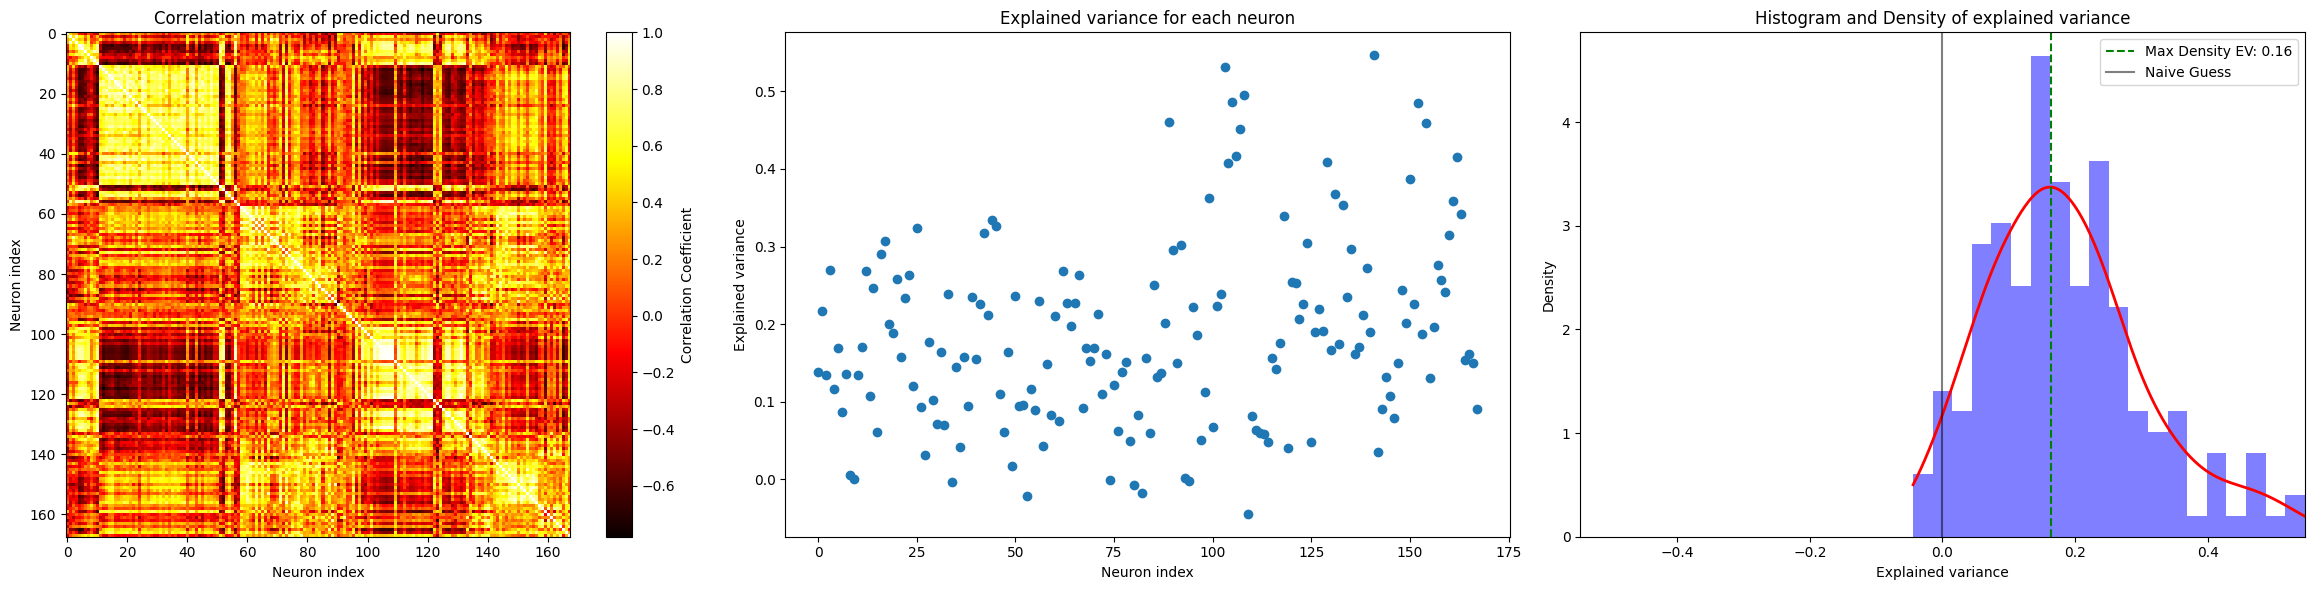

R2 Score: 0.17558467388153076
Explained Variance: 0.1859462559223175
Test MSE: 0.1119


(tensor([[ 0.1086,  0.0966,  0.2811,  ...,  0.1596,  0.0698, -0.0183],
         [-0.0640, -0.0746, -0.1367,  ...,  0.3562,  0.1543, -0.0231],
         [-0.0158, -0.2287,  0.1525,  ...,  0.1305, -0.1463,  0.0945],
         ...,
         [ 0.1481,  0.1201, -0.0219,  ...,  0.2220,  0.0898,  0.0123],
         [ 0.2219,  0.2329,  0.2918,  ...,  0.0993,  0.1149,  0.1142],
         [-0.1343, -0.1702, -0.0582,  ...,  0.2129,  0.0769,  0.1185]]),
 tensor([[-0.0879, -0.0164, -0.1340,  ...,  0.0284, -0.0085, -0.2074],
         [ 0.0270, -0.1447, -0.3623,  ...,  0.5289, -0.1783, -0.2455],
         [ 0.7358,  0.2244, -0.5893,  ...,  0.0200,  0.0358,  0.0454],
         ...,
         [-0.1834, -0.3004, -0.0761,  ..., -0.1735, -0.0329, -0.2970],
         [-0.0178, -0.0523,  0.8572,  ...,  0.1298,  0.3078,  0.1440],
         [-0.3014, -0.2094,  0.0112,  ...,  0.0796,  0.3452,  0.2394]]))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_loader, test_loader = get_dataloaders(16, stimulus_train, spikes_train, stimulus_val, spikes_val)

model = CNN(height=img_size, width=img_size, output_n=n_neurons)
model.load_state_dict(torch.load('cnn_w7.pt'))
model.to(device)

evaluate_model(model, train_loader, test_loader, device)

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [ ]:
import sys
#!{sys.executable} -m pip install gdown h5py

In [ ]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)

## Load the Data

In [ ]:
path_to_data = '.' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [ ]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


## Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

### Imports

In [ ]:
#!pip install timm

# Basic libraries
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

# For pre-trained Swin Transformer
import timm

### Best Neurons
Here we pick the best neurons to run our model on

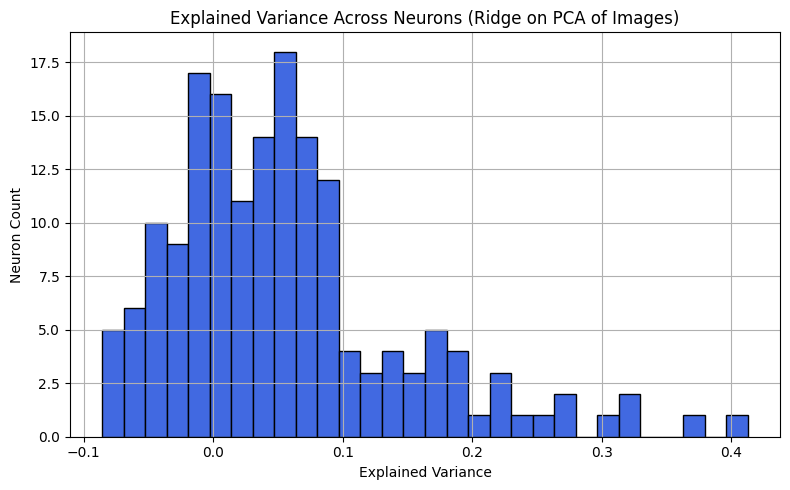

Top 5 Neuron EVs: [0.4126800298690796, 0.3775562644004822, 0.32649409770965576, 0.31353461742401123, 0.3097596764564514]
Mean EV across all neurons: 0.0554


In [ ]:


# Flatten images
X_train_flat = stimulus_train.reshape(len(stimulus_train), -1)
X_val_flat = stimulus_val.reshape(len(stimulus_val), -1)

# Apply PCA (reduce image dimensions)
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Run Ridge regression for each neuron
ev_all = []
for i in range(spikes_train.shape[1]):
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_pca, spikes_train[:, i])
    preds = ridge.predict(X_val_pca)
    ev = explained_variance_score(spikes_val[:, i], preds)
    ev_all.append(ev)

# Plot histogram of explained variances
plt.figure(figsize=(8, 5))
plt.hist(ev_all, bins=30, color='royalblue', edgecolor='black')
plt.title("Explained Variance Across Neurons (Ridge on PCA of Images)")
plt.xlabel("Explained Variance")
plt.ylabel("Neuron Count")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Top 5 Neuron EVs: {sorted(ev_all, reverse=True)[:5]}")
print(f"Mean EV across all neurons: {np.mean(ev_all):.4f}")


In [ ]:
# ev_all is the list of EVs for all 168 neurons
out_dim = 20
top_neurons = np.argsort(ev_all)[-out_dim:]  # top K neuron indices
print("Top neuron indices:", top_neurons)

spikes_train_top = spikes_train[:, top_neurons]
spikes_val_top = spikes_val[:, top_neurons]

Top neuron indices: [  3 152 154 135 167 104 105 121 140  90 123 157 108  99 134 162  69 103
 101 141]


### Setup Pytorch Dataset Class

In [ ]:
# Mean & std from ImageNet for pretrained Swin Transformer
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts (H, W, C) numpy → (C, H, W) tensor AND scales to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

from PIL import Image

class NeuralDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # shape (3, 224, 224)
        target = self.targets[idx].astype(np.float32)

        # If shape is (C, H, W), transpose to (H, W, C)
        if img.shape[0] == 3 and img.ndim == 3:
            img = np.transpose(img, (1, 2, 0))  # Now (224, 224, 3)
        else:
            raise ValueError(f"Unexpected image shape at index {idx}: {img.shape}")

        img = img.astype(np.uint8)
        img = Image.fromarray(img, mode='RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(target)

### Create Dataloader

In [ ]:
# DEcided to just use the TensorDataset and DataLoader from PyTorch, no need for the NeuralDataset
batch_size = 32

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(stimulus_train).float(), torch.tensor(spikes_train_top).float())
val_dataset = TensorDataset(torch.tensor(stimulus_val).float(), torch.tensor(spikes_val_top).float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

imgs, labels = next(iter(train_loader))
print(imgs.shape)  # should be [B, 3, 224, 224]
print(imgs.min(), imgs.max())  # should be around -2.1 to +2.6

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)


### Model Architecture and Rationale

Now, we will build the prediction model from a pretrained Swin Transformer Tiny backbone, and a simple MLP decoder to map the global feature vector to 168 firing rates. In this case, we wish to encorporate global features, hence the use of a transformer, where we try to emulate the brain by attempting to understand global features and see the performance 

We also use a CNN branch of a pre-trained resnet50 in parallel, which we concatenate and add into a decoder to predict the firing rates

The resnet50 will only go until layer2, as we saw in the previous weeks that is where we have the highest explained variance

### Define Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

# ResNet50 (CNN branch)
from torchvision.models import resnet50, ResNet50_Weights


class Swin_ResNet50_Hybrid(nn.Module):
    def __init__(self, hidden_dim=832, freeze_swin=True, freeze_cnn=True, out_dim=20):
        super().__init__()

        # ResNet50 (CNN branch)
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.cnn_branch = nn.Sequential(*list(resnet.children())[:-6])  # (B, 2048, 7, 7)
        self.pool_cnn = nn.AdaptiveAvgPool2d((1, 1))  # (B, 512, 1, 1)
        self.output_scale = nn.Parameter(torch.tensor(1.0))  # add in model init

        if freeze_cnn:
            for p in self.cnn_branch.parameters():
                p.requires_grad = False


        # Swin Tiny (Transformer branch)
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0)

        if freeze_swin:
            for p in self.swin.parameters():
                p.requires_grad = False
    

        self.decoder = nn.Sequential(
        nn.Linear(832, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, out_dim)  # top 20 neurons
    )



    def forward(self, x):
        cnn_feats = self.cnn_branch(x)
        cnn_feats = self.pool_cnn(cnn_feats).flatten(1)

        swin_feats = self.swin(x)

        feats = torch.cat([cnn_feats, swin_feats], dim=1)
        x = self.decoder(feats)
        return self.output_scale * x
    
    

### Initialize model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
# model = HybridResNetSwin().to(device)
model = Swin_ResNet50_Hybrid(freeze_cnn=False, freeze_swin=False).to(device)

print("Model loaded to:", device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Model loaded to: cuda


### Define Loss, Optimizer, and Metrics to judge

In [ ]:
# Utility: compute metrics
def compute_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Explained Variance, this is how we will judge the model against other models
    ev = explained_variance_score(y_true, y_pred, multioutput='raw_values')
    mean_ev = np.mean(ev)

    # Pearson Correlation (per neuron)
    correlations = []
    for i in range(y_true.shape[1]):
        try:
            corr = pearsonr(y_true[:, i], y_pred[:, i])[0]
            correlations.append(corr)
        except:
            correlations.append(np.nan)
    mean_corr = np.nanmean(correlations)
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())

    return mean_ev, mean_corr, rmse


### Training Loop

In [ ]:
def train(model, train_loader, val_loader, epochs=10):
    train_losses = []
    val_evs = []
    val_corrs = []
    val_rmses = []
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)


        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                preds = model(imgs)
                all_preds.append(preds)
                all_targets.append(targets)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        val_ev, val_corr, val_rmse = compute_metrics(all_targets, all_preds)
        train_losses.append(train_loss)
        val_evs.append(val_ev)
        val_corrs.append(val_corr)
        val_rmses.append(val_rmse)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val EV: {val_ev:.4f} | Val Corr: {val_corr:.4f}, | Val RMSE: {val_rmse:.4f}")
    plt.plot(val_evs, label = "EV")
    plt.plot(val_corrs, label = "Correlation")
    plt.plot(val_rmses, label = "validation RMS"); plt.title("Validation RMS, correlation, and EV");  plt.legend(); plt.show()

    return train_losses, val_evs, val_corrs, val_rmses, model

Epoch 1/100 | Train Loss: 0.1453 | Val EV: 0.3819 | Val Corr: 0.6289, | Val RMSE: 0.3292
Epoch 2/100 | Train Loss: 0.0977 | Val EV: 0.5210 | Val Corr: 0.7227, | Val RMSE: 0.2865
Epoch 3/100 | Train Loss: 0.0794 | Val EV: 0.5803 | Val Corr: 0.7619, | Val RMSE: 0.2629
Epoch 4/100 | Train Loss: 0.0694 | Val EV: 0.5957 | Val Corr: 0.7712, | Val RMSE: 0.2540
Epoch 5/100 | Train Loss: 0.0613 | Val EV: 0.6134 | Val Corr: 0.7841, | Val RMSE: 0.2522
Epoch 6/100 | Train Loss: 0.0559 | Val EV: 0.6249 | Val Corr: 0.7895, | Val RMSE: 0.2441
Epoch 7/100 | Train Loss: 0.0503 | Val EV: 0.6259 | Val Corr: 0.7964, | Val RMSE: 0.2439
Epoch 8/100 | Train Loss: 0.0462 | Val EV: 0.6409 | Val Corr: 0.7992, | Val RMSE: 0.2382
Epoch 9/100 | Train Loss: 0.0428 | Val EV: 0.6412 | Val Corr: 0.7995, | Val RMSE: 0.2377
Epoch 10/100 | Train Loss: 0.0400 | Val EV: 0.6403 | Val Corr: 0.8010, | Val RMSE: 0.2388
Epoch 11/100 | Train Loss: 0.0367 | Val EV: 0.6370 | Val Corr: 0.8006, | Val RMSE: 0.2395
Epoch 12/100 | Trai

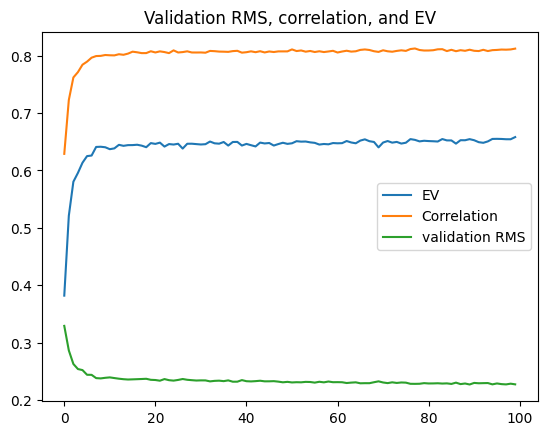

In [ ]:
train_losses, val_evs, val_corrs, val_rmses, trained_model = train(model, train_loader, val_loader, epochs=100)

We can see that for a small amount of IT neurons, we can reach up to quite a high value for explained variance. This is logical, as neurons do exhibit some amount of grandmother cell coding, hence they fire at a certain rate based on the whole image, similar to a classifier, and that behaviour is exhibited only for a few amount of neurons, as we only have a small number of actual classes (table, etc)

In [ ]:
torch.save(model.state_dict(), "hybrid_model_top20.pth")

# store train_losses, val_evs, val_corrs, val_rmses
import pickle
with open('train_metrics_20.pkl', 'wb') as f:
    pickle.dump((train_losses, val_evs, val_corrs, val_rmses), f)

### Next, attempt to fit the model on all the neurons, not just the top 20

Model loaded to: cuda
Epoch 1/100 | Train Loss: 0.1322 | Val EV: 0.0982 | Val Corr: 0.3054, | Val RMSE: 0.3520
Epoch 2/100 | Train Loss: 0.1124 | Val EV: 0.2255 | Val Corr: 0.4724, | Val RMSE: 0.3197
Epoch 3/100 | Train Loss: 0.0962 | Val EV: 0.3014 | Val Corr: 0.5373, | Val RMSE: 0.2990
Epoch 4/100 | Train Loss: 0.0868 | Val EV: 0.3329 | Val Corr: 0.5638, | Val RMSE: 0.2888
Epoch 5/100 | Train Loss: 0.0810 | Val EV: 0.3631 | Val Corr: 0.5893, | Val RMSE: 0.2815
Epoch 6/100 | Train Loss: 0.0763 | Val EV: 0.3811 | Val Corr: 0.6036, | Val RMSE: 0.2762
Epoch 7/100 | Train Loss: 0.0722 | Val EV: 0.3963 | Val Corr: 0.6154, | Val RMSE: 0.2714
Epoch 8/100 | Train Loss: 0.0688 | Val EV: 0.4076 | Val Corr: 0.6243, | Val RMSE: 0.2675
Epoch 9/100 | Train Loss: 0.0661 | Val EV: 0.4093 | Val Corr: 0.6262, | Val RMSE: 0.2677
Epoch 10/100 | Train Loss: 0.0637 | Val EV: 0.4238 | Val Corr: 0.6366, | Val RMSE: 0.2629
Epoch 11/100 | Train Loss: 0.0612 | Val EV: 0.4285 | Val Corr: 0.6408, | Val RMSE: 0.26

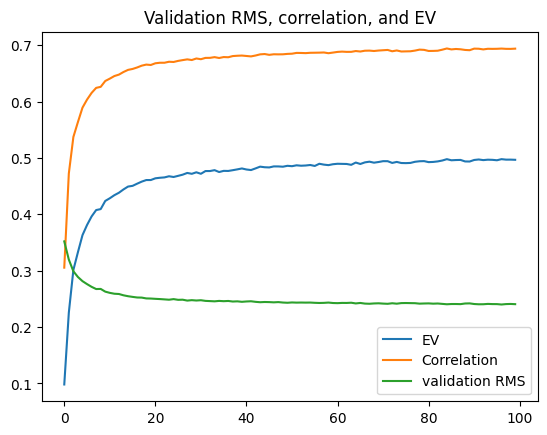

In [ ]:
batch_size = 32

train_dataset_full = TensorDataset(torch.tensor(stimulus_train).float(), torch.tensor(spikes_train).float())
val_dataset_full = TensorDataset(torch.tensor(stimulus_val).float(), torch.tensor(spikes_val).float())

train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_full   = DataLoader(val_dataset_full, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()

model_full = Swin_ResNet50_Hybrid(freeze_cnn=False, freeze_swin=False, out_dim=168).to(device)

print("Model loaded to:", device)

# Optimizer
optimizer = torch.optim.AdamW(model_full.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_losses_full, val_evs_full, val_corrs_full, val_rmses_full, trained_model_full = train(model_full, train_loader_full, val_loader_full, epochs=100)

In [ ]:
torch.save(model_full.state_dict(), "hybrid_model_full_neurons.pth")

# store train_losses, val_evs, val_corrs, val_rmses
import pickle
with open('train_metrics_full.pkl', 'wb') as f:
    pickle.dump((train_losses_full, val_evs_full, val_corrs_full, val_rmses_full), f)

# Test the best performing model on new data

The model is found on the drive link below

## Load the Data

In [ ]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import torch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn

import timm
from torchvision import transforms
import os
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from scipy.stats import pearsonr


url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
url_for_model_pth = "https://drive.google.com/file/d/1juTYaYtclApJXCJoHm278LF3fLVjl-W-/view?usp=sharing"
output = "IT_data.h5"
output_for_model = "hybrid_model_full_neurons.pth"
gdown.download(url, output, quiet=False, fuzzy=True)
gdown.download(url_for_model_pth, output_for_model, quiet=False, fuzzy=True)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
path_to_data = '.' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

### How to use:

Suppose your data is $ \textbf{stimulus\_val} $ (or $ \textbf{stimulus\_test} $). You also have a model `hybrid_model_full_neurons.pth`, which can be also obtained by running the `week8` part of the notebook if it is not downloading. Then, just run the following below:

You get the predictions, and then the metrics, which you can compare with your ground truth (suppose it is called ```spikes_val```)

In [ ]:
#test.py


# model definition
class Swin_ResNet50_Hybrid(nn.Module):
    def __init__(self, hidden_dim=832, freeze_swin=True, freeze_cnn=True, out_dim=168):
        super().__init__()

        # ResNet50 (CNN branch)
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.cnn_branch = nn.Sequential(*list(resnet.children())[:-6])  # Only go up to and include layer 2
        self.pool_cnn = nn.AdaptiveAvgPool2d((1, 1))  # (B, 512, 1, 1)
        self.output_scale = nn.Parameter(torch.tensor(1.0))  # add in model init
        self.out_dim = out_dim
        if freeze_cnn:
            for p in self.cnn_branch.parameters():
                p.requires_grad = False


        # Swin Tiny (Transformer branch)
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0)

        if freeze_swin:
            for p in self.swin.parameters():
                p.requires_grad = False
    

        self.decoder = nn.Sequential(
        nn.Linear(832, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, self.out_dim)  # all neurons
    )



    def forward(self, x):
        cnn_feats = self.cnn_branch(x)
        cnn_feats = self.pool_cnn(cnn_feats).flatten(1)

        swin_feats = self.swin(x)

        feats = torch.cat([cnn_feats, swin_feats], dim=1)
        x = self.decoder(feats)
        return self.output_scale * x


# -----------------------------------------------------

def predict_stimulus(
    stimulus_test,
    model_path,
    out_dim=168,
    batch_size=32,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load stimulus
    stimulus_tensor = torch.tensor(stimulus_test).float()

    dataset = TensorDataset(stimulus_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)

    # Load model
    model = Swin_ResNet50_Hybrid(out_dim=out_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Predict
    all_preds = []
    with torch.no_grad():
        for (batch,) in loader:
            batch = batch.to(device)
            preds = model(batch)
            all_preds.append(preds.cpu())

    predictions = torch.cat(all_preds, dim=0).numpy()  # shape [N, out_dim]
    return predictions



### Predict the stimulus

In [ ]:
preds = predict_stimulus(stimulus_val, "hybrid_model_full_neurons.pth",batch_size=len(stimulus_val), out_dim = 168)

Correlation Coefficients:  0.6976877
Explained Variance:  0.5014946
Mean Squared Error:  0.23990297


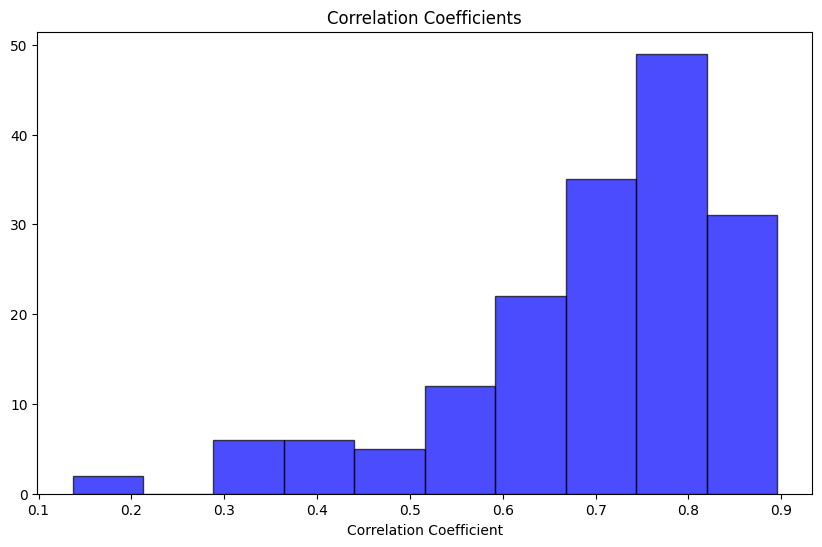

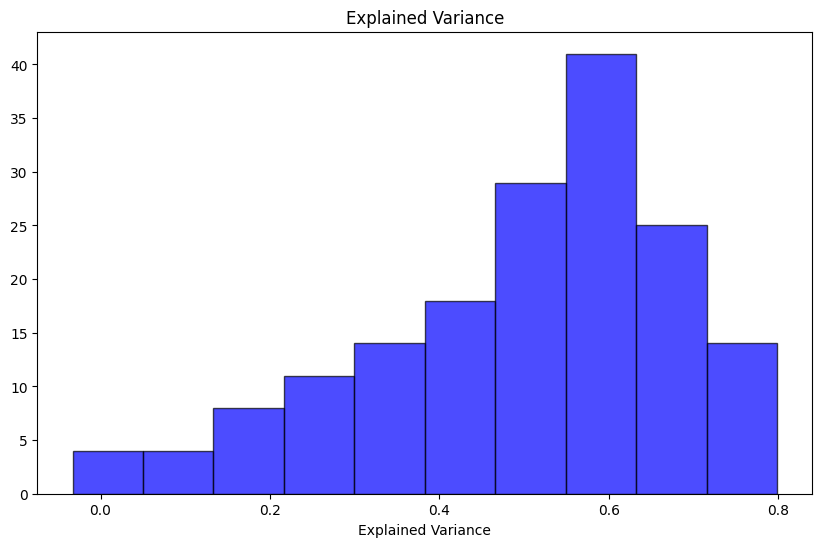

In [ ]:
# calculate correlation adn EV of the predictions

def compute_metrics(y_true, y_pred):

    # Explained Variance, this is how we will judge the model against other models
    ev = explained_variance_score(y_true, y_pred, multioutput='raw_values')
    mean_ev = np.mean(ev)

    # Pearson Correlation (per neuron)
    correlations = []
    for i in range(y_true.shape[1]):
        try:
            corr = pearsonr(y_true[:, i], y_pred[:, i])[0]
            correlations.append(corr)
        except:
            correlations.append(np.nan)
    mean_corr = np.nanmean(correlations)
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())

    return mean_ev, mean_corr, ev, correlations, rmse

mean_ev, mean_corr, ev, corr, rmse = compute_metrics(spikes_val, preds)
print("Correlation Coefficients: ", mean_corr)
print("Explained Variance: ", mean_ev)
print("Mean Squared Error: ", rmse)

plt.figure(figsize=(10,6))
plt.hist(corr, bins=10, alpha=0.7, color = 'blue', edgecolor='black')
plt.title('Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.show()
plt.figure(figsize=(10,6))
plt.hist(ev, bins=10, alpha=0.7, color = 'blue', edgecolor='black')
plt.title('Explained Variance')
plt.xlabel('Explained Variance')
plt.show()